# **(Part III) Benchmarking scAtlasVAE with another methods**
        
  
This notebook contains codes for benchmarking scAtlasVAE.

    
Please check the package version at https://github.com/WanluLiuLab/scAtlasVAE/blob/master/environment.yml for reproducing the results. 
    
For more information about the scAtlasVAE model, please see https://scatlasvae.readthedocs.io/en/latest/.
    
For retrieving datasets, please see https://zenodo.org/records/10472914.

## Initializing Benchmarking Environment

In [ ]:
#########################################
# Initializing Benchmarking Environment #
#########################################

import scatlasvae
import scanpy as sc
import scvi # scvi==1.0.4
import scarches # 
import scib
import scanorama
import celltypist

# import packages
import scanpy as sc # import scanpy
import matplotlib
import matplotlib.pyplot as plt # import matplotlib
import numpy as np # import numpy
import pandas as pd # import pandas
import gc # import garbage collector
from typing import Literal, Union # import typing
import time

# set plot linewidth
def setPltLinewidth(linewidth:float): # define function to set plot linewidth
    matplotlib.rcParams['axes.linewidth'] = linewidth # set plot linewidth
setPltLinewidth(1) # set plot linewidth to 1

# set plot parameters
plt.rcParams['figure.dpi'] = 300 # set figure resolution
plt.rcParams['savefig.dpi'] = 300 # set figure resolution
plt.rcParams['font.size'] = 8 # set font size
plt.rcParams['axes.linewidth'] = 1 # set plot linewidth
plt.rcParams['font.family'] = 'Arial' # set font family

In [ ]:
# Load dataset

adata_cd8 = sc.read_h5ad('huARdb_v2_GEX.CD8.hvg4k.h5ad')
adata_cd8_zheng = sc.read_h5ad('adata_cd8_zheng.h5ad')
adata_cd8_chu = sc.read_h5ad('adata_cd8_chu.h5ad')
adata_cd8_multi_atlas = sc.read_h5ad(
    'huARdb_v2_GEX.CD8.hvg4k.pan_cancer_multi_atlas_vae.h5ad'
)

In [ ]:
# Useful functions

try:
    import seaborn as sns
    import matplotlib
    import matplotlib.pyplot as plt


    matplotlib.rcParams['font.family'] = 'Arial'
    matplotlib.rcParams['font.size'] = '10'
    matplotlib.rcParams['font.weight'] = 100
    matplotlib.rcParams['axes.linewidth'] = 2
    matplotlib.rcParams['axes.edgecolor'] = "#000000"

    def createFig(figsize=(8, 4)):
        fig,ax=plt.subplots()           
        ax.spines['right'].set_color('none')     
        ax.spines['top'].set_color('none')
        #ax.spines['bottom'].set_color('none')     
        #ax.spines['left'].set_color('none')
        for line in ax.yaxis.get_ticklines():
            line.set_markersize(5)
            line.set_color("#585958")
            line.set_markeredgewidth(0.5)
        for line in ax.xaxis.get_ticklines():
            line.set_markersize(5)
            line.set_markeredgewidth(0.5)
            line.set_color("#585958")
        ax.set_xbound(0,10)
        ax.set_ybound(0,10)
        fig.set_size_inches(figsize)
        return fig,ax

    def createSubplots(nrow,ncol, figsize=(8,8),gridspec_kw={}):
        fig,axes=plt.subplots(nrow, ncol, gridspec_kw=gridspec_kw)
        for ax in axes.flatten():
            ax.spines['right'].set_color('none')     
            ax.spines['top'].set_color('none')
            for line in ax.yaxis.get_ticklines():
                line.set_markersize(5)
                line.set_color("#585958")
                line.set_markeredgewidth(0.5)
            for line in ax.xaxis.get_ticklines():
                line.set_markersize(5)
                line.set_markeredgewidth(0.5)
                line.set_color("#585958")
        fig.set_size_inches(figsize)
        return fig,axes

    hist_kws={"linewidth": 0, "alpha": .5}
except:
    print("failed to load plotting packages")

## Main Benchmarking Script

### Benchmark Zheng et al., 2019 Dataset

#### Benchmarking integration performance

In [ ]:
##############
# scAtlasVAE #
##############

vae_model = scatlasvae.model.scAtlasVAE(
    adata=adata_cd8_zheng,
    batch_key=["sample_name", "study_name"],
    batch_embedding="embedding",
    batch_hidden_dim=64,
    device="cuda:0",
)
vae_model.fit(max_epoch=10, lr=5e-5)
adata_cd8_zheng.obsm["X_gex"] = vae_model.get_latent_embedding(show_progress=True)


vae_model = scatlasvae.model.scAtlasVAE(
    adata=adata_cd8_zheng,
    batch_key=["sample_name", "study_name"],
    batch_embedding="embedding",
    batch_hidden_dim=64,
    label_key="cell_subtype_zheng_2021",
    device="cuda:0",
)
vae_model.fit(max_epoch=10, lr=5e-5)
adata_cd8_zheng.obsm["X_gex_supervised"] = vae_model.get_latent_embedding(
    show_progress=True
)


###################
# scVI and scANVI #
###################

scvi.model.SCVI.setup_anndata(
    adata_cd8_zheng, batch_key="sample_name", categorical_covariate_keys=["study_name"]
)
model = scvi.model.SCVI(adata_cd8_zheng)
model.train(max_epochs=10)
adata_cd8_zheng.obsm["X_scVI"] = model.get_latent_representation()


scvi.model.SCANVI.setup_anndata(
    adata_cd8_zheng,
    batch_key="sample_name",
    categorical_covariate_keys=["study_name"],
    labels_key="cell_subtype_zheng_2021",
    unlabeled_category="undefined",
)
model = scvi.model.SCANVI(adata_cd8_zheng)
model.train(max_epochs=10)
adata_cd8_zheng.obsm["X_scANVI"] = model.get_latent_representation()


##########
# scPoli #
##########

scpoli_model = scarches.models.scpoli.scPoli(
    adata=adata_cd8_zheng,
    condition_keys=["sample_name", "study_name"],
    recon_loss="zinb",
)
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
scpoli_model.train(
    n_epochs=10,
    pretraining_epochs=5,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)
for i in tqdm.trange(0, len(adata_cd8_zheng), 320):
    Z.append(scpoli_model.get_latent(adata_cd8_zheng[i : i + 320]))
adata_cd8_zheng.obsm["X_scPoli"] = Z


scpoli_model = scarches.models.scpoli.scPoli(
    adata=adata_cd8_zheng,
    condition_keys=["sample_name", "study_name"],
    recon_loss="zinb",
    cell_type_keys=["cell_subtype_zheng_2021"],
    unknown_ct_names=["undefined"],
)
scpoli_model.train(
    n_epochs=10,
    pretraining_epochs=5,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)
Z = []
import tqdm

# scpoli_model.
for i in tqdm.trange(0, len(adata_cd8_zheng), 320):
    Z.append(scpoli_model.get_latent(adata_cd8_zheng[i : i + 320]))
adata_cd8_zheng.obsm["X_scPoli_supervised"] = Z


##########
# SCALEX #
##########

os.chdir("~/Biosoft/SCALEX")
from scalex import SCALEX

adata_cd8_zheng.obsm["X"] = adata_cd8_zheng.X
adata_cd8_zheng_scalex = SCALEX(
    adata_cd8_zheng,
    batch_name=["study_name"],
    n_top_features=adata_cd8_zheng.shape[1],
    min_cells=1,
    min_features=1,
    use_layer="X",
    ignore_umap=True,
)
adata_cd8_zheng.obsm["X_SCALEX"] = adata_cd8_zheng_scalex.obsm["latent"]

###########
# Harmony #
###########

from harmony import harmonize

sc.pp.normalize_total(adata_cd8_zheng)
sc.pp.log1p(adata_cd8_zheng)
sc.tl.pca(adata_cd8_zheng)
adata_cd8_zheng.obsm["X_harmony"] = harmonize(
    adata_cd8_zheng.obsm["X_pca"], adata_cd8_zheng.obs, batch_key="study_name"
)

#############
# Scanoarma #
#############


def scanoramaCorrectMerge(adata, groupby="sample_name"):
    adatas = []
    group_names = list(np.unique(adata.obs[groupby]))
    for i in group_names:
        adatas.append(adata[adata.obs[groupby] == i])
    corrected = scanorama.correct_scanpy(adatas, dimred=10, return_dimred=True)
    return sc.concat(corrected)[adata.obs.index]


adata_cd8_zheng.obsm["X_scanorama"] = scanoramaCorrectMerge(
    adata_cd8_zheng, groupby="study_name"
).obsm["X_scanorama"]

In [ ]:
silhouette_batch_result = {"sample_name": {}, "study_name": {}}
for emb_key in [
    "X_gex",
    "X_gex_supervised",
    "X_scANVI",
    "X_scVI",
    "X_scPoli",
    "X_scPoli_supervised",
    "X_pca",
    "X_harmony",
    "X_scanorama",
    "X_DESC",
    "X_SCALEX",
    "X_RPCA",
    "X_CCA",
]:
    if emb_key in adata_cd8_zheng.obsm.keys():
        adata_ = adata_cd8_zheng[
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"] != "undefined"
        ]
        sc.pp.neighbors(adata_, use_rep=emb_key)
        silhouette_batch_result["sample_name"][emb_key] = scib.me.silhouette_batch(
            adata_,
            batch_key="sample_name",
            label_key="cell_subtype_zheng_2021",
            embed=emb_key,
        )
        silhouette_batch_result["study_name"][emb_key] = scib.me.silhouette_batch(
            adata_,
            batch_key="study_name",
            label_key="cell_subtype_zheng_2021",
            embed=emb_key,
        )

silhouette_result = {"study_name": {}}
for emb_key in [
    "X_gex",
    "X_gex_supervised",
    "X_scANVI",
    "X_scVI",
    "X_scPoli",
    "X_scPoli_supervised",
    "X_pca",
    "X_harmony",
    "X_scanorama",
    "X_DESC",
    "X_SCALEX",
]:
    if emb_key in adata_cd8_zheng.obsm.keys():
        adata_ = adata_cd8_zheng[
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"] != "undefined"
        ]
        sc.pp.neighbors(adata_, use_rep=emb_key)
        silhouette_result["study_name"][emb_key] = scib.me.silhouette(
            adata_, label_key="cell_subtype_zheng_2021", embed=emb_key
        )

graph_connectivity_result = {}
for emb_key in [
    "X_gex",
    "X_gex_supervised",
    "X_scANVI",
    "X_scVI",
    "X_scPoli",
    "X_scPoli_supervised",
    "X_pca",
    "X_harmony",
    "X_scanorama",
    "X_DESC",
    "X_SCALEX",
    "X_RPCA",
    "X_CCA",
]:
    if emb_key in adata_cd8_zheng.obsm.keys():
        adata_ = adata_cd8_zheng[
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"] != "undefined"
        ]
        sc.pp.neighbors(adata_, use_rep=emb_key)
        graph_connectivity_result[emb_key] = scib.me.graph_connectivity(
            adata_,
            label_key="cell_subtype_zheng_2021",
        )

pcr_comparison_result = {"sample_name": {}, "study_name": {}}
for emb_key in [
    "X_gex",
    "X_gex_supervised",
    "X_scANVI",
    "X_scVI",
    "X_scPoli",
    "X_scPoli_supervised",
    "X_pca",
    "X_harmony",
    "X_scanorama",
    "X_RPCA",
    "X_CCA",
    "X_SCALEX",
]:
    if emb_key in adata_cd8_zheng.obsm.keys():
        adata_ = adata_cd8_zheng[
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"] != "undefined"
        ]
        # sc.pp.neighbors(adata_, use_rep=emb_key)
        pcr_comparison_result["study_name"][emb_key] = scib.me.pcr_comparison(
            adata_, adata_, covariate="study_name", embed=emb_key, n_comps=10
        )
        pcr_comparison_result["sample_name"][emb_key] = scib.me.pcr_comparison(
            adata_, adata_, covariate="sample_name", embed=emb_key, n_comps=10
        )


isolated_labels_asw_result = {"sample_name": {}, "study_name": {}}
for emb_key in [
    "X_gex",
    "X_gex_supervised",
    "X_scANVI",
    "X_scVI",
    "X_scPoli",
    "X_scPoli_supervised",
    "X_pca",
    "X_harmony",
    "X_scanorama",
    "X_DESC",
    "X_SCALEX",
    "X_RPCA",
    "X_CCA",
]:
    if emb_key in adata_cd8_zheng.obsm.keys():
        adata_ = adata_cd8_zheng[
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"] != "undefined"
        ]
        sc.pp.neighbors(adata_, use_rep=emb_key)
        isolated_labels_asw_result["sample_name"][
            emb_key
        ] = scib.me.isolated_labels_asw(
            adata_,
            label_key="cell_subtype_zheng_2021",
            embed=emb_key,
            batch_key="sample_name",
        )
        isolated_labels_asw_result["study_name"][emb_key] = scib.me.isolated_labels_asw(
            adata_,
            label_key="cell_subtype_zheng_2021",
            embed=emb_key,
            batch_key="study_name",
        )
isolated_labels_f1_result = {"sample_name": {}, "study_name": {}}
for emb_key in [
    "X_gex",
    "X_gex_supervised",
    "X_scANVI",
    "X_scVI",
    "X_scPoli",
    "X_scPoli_supervised",
    "X_pca",
    "X_harmony",
    "X_scanorama",
    "X_DESC",
    "X_SCALEX",
    "X_RPCA",
    "X_CCA",
]:
    if emb_key in adata_cd8_zheng.obsm.keys():
        adata_ = adata_cd8_zheng[
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"] != "undefined"
        ]
        sc.pp.neighbors(adata_, use_rep=emb_key)
        isolated_labels_f1_result["sample_name"][emb_key] = scib.me.isolated_labels_f1(
            adata_,
            label_key="cell_subtype_zheng_2021",
            embed=emb_key,
            batch_key="sample_name",
        )
        isolated_labels_f1_result["study_name"][emb_key] = scib.me.isolated_labels_f1(
            adata_,
            label_key="cell_subtype_zheng_2021",
            embed=emb_key,
            batch_key="study_name",
        )

#### Benchmarking label transfer performance

##### Left 5% random cells from study

In [ ]:
import sklearn
from sklearn.metrics import roc_auc_score

roc_auc_scores_scatlasvae_zero_shot = {
    i: [] for i in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
}
for i in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    for _ in range(3):
        l = list(range(adata_cd8_zheng.shape[0]))
        train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)

        adata_cd8_zheng_train = adata_cd8_zheng[train]
        adata_cd8_zheng_test = adata_cd8_zheng[test]
        vae_model = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_zheng_train,
            batch_key=["sample_name", "study_name"],
            batch_embedding="embedding",
            batch_hidden_dim=64,
            label_key="cell_subtype_zheng_2021",
            device="cuda:0",
        )

        vae_model.fit(
            max_epoch=10,
            lr=5e-5,
            pred_weight=i,
        )
        checkpoint_path = "./adata_cd8_zheng_models/left.model"
        vae_model.save_to_disk(checkpoint_path)
        import torch

        state_dict = torch.load(checkpoint_path, map_location="cpu")
        config = state_dict["model_config"]
        vae_model_test = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_zheng_test,
            pretrained_state_dict=state_dict["model_state_dict"],
            **config,
        )
        from sklearn.metrics import roc_auc_score

        vae_model_test.eval()
        label_predictions = vae_model_test.predict_labels().detach().cpu().numpy()
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(list(map(lambda x: x[-2], vae_model_test._dataset)))[
                [vae_model_test._shuffle_indices]
            ].unsqueeze(1),
            vae_model_test.n_label + 1,
        )
        roc_auc_scores_scatlasvae_zero_shot[i].append(
            roc_auc_score(y, label_predictions, average=None).mean()
        )

roc_auc_scores_scatlasvae_full_shot = {
    i: [] for i in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
}
for i in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    for _ in range(10):
        l = list(range(adata_cd8_zheng.shape[0]))
        train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)
        adata_cd8_zheng.obs["cell_subtype_zheng_2021_scAtlasVAE"] = list(
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"]
        )
        adata_cd8_zheng.obs.iloc[
            test,
            list(adata_cd8_zheng.obs.columns).index(
                "cell_subtype_zheng_2021_scAtlasVAE"
            ),
        ] = "undefined"
        vae_model = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_zheng,
            batch_key=["sample_name", "study_name"],
            batch_embedding="embedding",
            batch_hidden_dim=64,
            label_key="cell_subtype_zheng_2021_scANVI",
            device="cuda:0",
        )

        vae_model.fit(max_epoch=10, lr=5e-5, pred_weight=i)

        from sklearn.metrics import roc_auc_score

        vae_model.eval()
        label_predictions = vae_model.predict_labels().detach().cpu().numpy()
        col = list(vae_model.label_category.categories)
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(
                list(
                    map(
                        lambda x: col.index(x),
                        adata_cd8_zheng.obs["cell_subtype_zheng_2021"],
                    )
                )
            ).unsqueeze(1),
            vae_model.n_label + 1,
        )
        test_set = set(test)
        indices = np.array(
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"] != "undefined"
        ) & np.array(list(map(lambda x: x in test_set, range(len(adata_cd8_zheng)))))
        sel = y[indices][:, :-1].sum(0) > 0
        roc_auc_scores_scatlasvae_full_shot[i].append(
            roc_auc_score(
                y[indices][:, :-1][:, sel],
                label_predictions[indices][:, sel],
                average=None,
            ).mean()
        )

scANVI_roc_auc_scores = []
for _ in range(10):
    l = list(range(adata_cd8_zheng.shape[0]))
    train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)

    adata_cd8_zheng.obs["cell_subtype_zheng_2021_scANVI"] = list(
        adata_cd8_zheng.obs["cell_subtype_zheng_2021"]
    )
    adata_cd8_zheng.obs.iloc[
        test, list(adata_cd8_zheng.obs.columns).index("cell_subtype_zheng_2021_scANVI")
    ] = "undefined"

    scvi.model.SCANVI.setup_anndata(
        adata_cd8_zheng,
        batch_key="sample_name",
        categorical_covariate_keys=["study_name"],
        labels_key="cell_subtype_zheng_2021_scANVI",
        unlabeled_category="undefined",
    )

    model = scvi.model.SCANVI(adata_cd8_zheng)
    model.train(max_epochs=10)
    scanvi_prediction = model.predict(soft=True)
    col = list(scanvi_prediction.columns) + ["undefined"]

    y = scatlasvae.utils._tensor_utils.one_hot(
        torch.tensor(
            list(
                map(
                    lambda x: col.index(x),
                    adata_cd8_zheng.obs["cell_subtype_zheng_2021"],
                )
            )
        ).unsqueeze(1),
        len(col),
    )
    test = set(test)
    indices = list(
        map(
            lambda x: x[1] != "undefined" and x[0] in test,
            enumerate(adata_cd8_zheng.obs["cell_subtype_zheng_2021"]),
        )
    )

    scANVI_roc_auc_scores.append(
        roc_auc_score(y[indices], scanvi_prediction.to_numpy()[indices])
    )


scpoli_roc_auc_scores = []
for _ in range(10):
    l = list(range(adata_cd8_zheng.shape[0]))
    train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)
    adata_cd8_zheng_train = adata_cd8_zheng[train]
    adata_cd8_zheng_test = adata_cd8_zheng[test]

    scpoli_model = scarches.models.scpoli.scPoli(
        adata=adata_cd8_zheng_train[
            adata_cd8_zheng_train.obs["cell_subtype_zheng_2021"] != "undefined"
        ],
        condition_keys=["sample_name", "study_name"],
        cell_type_keys=["cell_subtype_zheng_2021"],
        unknown_ct_names=["undefined"],
        recon_loss="zinb",
    )
    early_stopping_kwargs = {
        "early_stopping_metric": "val_prototype_loss",
        "mode": "min",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    }
    scpoli_model.train(
        n_epochs=10,
        pretraining_epochs=5,
        early_stopping_kwargs=early_stopping_kwargs,
        eta=5,
        prototype_training=True,
    )
    # adata_cd8_zheng_test.obs.pop('cell_subtype_zheng_2021')
    # adata_cd8_zheng_test.obs['cell_subtype_zheng_2021'] = 'undefined'
    scpoli_query = scarches.models.scpoli.scPoli.load_query_data(
        adata=adata_cd8_zheng_test,
        reference_model=scpoli_model,
        labeled_indices=[],
    )
    scpoli_query.train(n_epochs=10, pretraining_epochs=5, eta=10)
    c = list(scpoli_query.cell_types_.keys())
    y = scatlasvae.utils._tensor_utils.one_hot(
        torch.tensor(
            list(
                map(
                    lambda x: c.index(x) if x in c else vae_model_test.n_label,
                    adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"],
                )
            )
        ).unsqueeze(1),
        len(c),
    )
    results_dict = scpoli_query.classify(adata_cd8_zheng_test, scale_uncertainties=True)
    indices = adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"] != "undefined"
    scpoli_roc_auc_scores.append(
        roc_auc_score(
            y[indices],
            1 - results_dict["cell_subtype_zheng_2021"]["weighted_distances"][indices],
        )
    )

roc_auc_scores_cell_typist = []
for _ in range(10):
    l = list(range(adata_cd8_zheng.shape[0]))
    train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)

    adata_cd8_zheng_train = adata_cd8_zheng[train]
    adata_cd8_zheng_train = adata_cd8_zheng_train[
        adata_cd8_zheng_train.obs["cell_subtype_zheng_2021"] != "undefined"
    ]
    adata_cd8_zheng_test = adata_cd8_zheng[test]
    adata_cd8_zheng_test = adata_cd8_zheng_test[
        adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"] != "undefined"
    ]

    sc.pp.normalize_total(adata_cd8_zheng_train, target_sum=1e4)
    sc.pp.log1p(adata_cd8_zheng_train)
    t_start = time.time()
    model_fs = celltypist.train(
        adata_cd8_zheng_train,
        "cell_subtype_zheng_2021",
        n_jobs=96,
        max_iter=5,
        use_SGD=True,
    )
    t_end = time.time()
    print(f"Time elapsed: {t_end - t_start} seconds")

    model_fs.write("./adata_cd8_zheng_models/cell_typist_model.pkl")

    sc.pp.normalize_total(adata_cd8_zheng_test, target_sum=1e4)
    sc.pp.log1p(adata_cd8_zheng_test)

    predictions = celltypist.annotate(
        adata_cd8_zheng_test, model="./adata_cd8_zheng_models/cell_typist_model.pkl"
    )

    col = list(predictions.probability_matrix.columns)
    y = scatlasvae.utils._tensor_utils.one_hot(
        torch.tensor(
            list(
                map(
                    lambda x: col.index(x),
                    adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"],
                )
            )
        ).unsqueeze(1),
        len(col),
    )
    from sklearn.metrics import roc_auc_score

    roc_auc_scores_cell_typist.append(
        roc_auc_score(y, predictions.probability_matrix.to_numpy(), average=None).mean()
    )

##### Left one study for prediction

In [ ]:
roc_auc_scores_scatlasvae_unseen = {}
for i in np.unique(adata_cd8_zheng.obs["study_name"]):
    if i not in roc_auc_scores_scatlasvae_unseen.keys():
        adata_cd8_zheng_train = adata_cd8_zheng[adata_cd8_zheng.obs["study_name"] != i]
        adata_cd8_zheng_test = adata_cd8_zheng[adata_cd8_zheng.obs["study_name"] == i]
        adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"] = pd.Categorical(
            adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"],
            categories=adata_cd8_zheng_train.obs[
                "cell_subtype_zheng_2021"
            ].cat.categories,
        )
        vae_model = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_zheng_train,
            batch_key=["sample_name", "study_name"],
            batch_embedding="embedding",
            batch_hidden_dim=64,
            label_key="cell_subtype_zheng_2021",
            device="cuda:0",
        )

        vae_model.fit(max_epoch=10, lr=5e-5, pred_weight=5.0)
        checkpoint_path = "./adata_cd8_zheng_models/left.model"
        vae_model.save_to_disk(checkpoint_path)
        # adata_cd8_zheng_test = scatlasvae.model.scAtlasVAE.setup_anndata(
        #    adata_cd8_zheng_test,
        #    checkpoint_path
        # )
        import torch

        state_dict = torch.load(checkpoint_path, map_location="cpu")
        config = state_dict["model_config"]
        vae_model_test = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_zheng_test,
            pretrained_state_dict=state_dict["model_state_dict"],
            **config,
        )
        from sklearn.metrics import roc_auc_score

        vae_model_test.eval()
        label_predictions = vae_model_test.predict_labels().detach().cpu().numpy()
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(list(map(lambda x: x[-2], vae_model_test._dataset)))[
                [vae_model_test._shuffle_indices]
            ].unsqueeze(1),
            vae_model_test.n_label + 1,
        )
        indices = adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"] != "undefined"
        sel = y[indices][:, :-1].sum(0) > 0
        roc_auc_scores_scatlasvae_unseen[i] = roc_auc_score(
            y[indices][:, :-1][:, sel], label_predictions[indices][:, sel], average=None
        ).mean()

roc_auc_scores_scatlasvae_seen = {}
for i in np.unique(adata_cd8_zheng.obs["study_name"]):
    if i not in roc_auc_scores_scatlasvae_seen.keys():
        adata_cd8_zheng.obs["cell_subtype_zheng_2021_scANVI"] = list(
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"]
        )
        adata_cd8_zheng.obs.loc[
            adata_cd8_zheng.obs["study_name"] == i, "cell_subtype_zheng_2021_scANVI"
        ] = "undefined"
        vae_model = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_zheng,
            batch_key=["sample_name", "study_name"],
            batch_embedding="embedding",
            batch_hidden_dim=64,
            label_key="cell_subtype_zheng_2021_scANVI",
            device="cuda:0",
        )

        vae_model.fit(max_epoch=10, lr=5e-5, pred_weight=5.0)

        from sklearn.metrics import roc_auc_score

        vae_model.eval()
        col = list(vae_model.label_category.categories)
        label_predictions = vae_model.predict_labels().detach().cpu().numpy()
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(
                list(
                    map(
                        lambda x: col.index(x),
                        adata_cd8_zheng.obs["cell_subtype_zheng_2021"],
                    )
                )
            ).unsqueeze(1),
            vae_model.n_label + 1,
        )
        indices = np.array(
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"] != "undefined"
        ) & np.array(adata_cd8_zheng.obs["study_name"] == i)
        sel = y[indices][:, :-1].sum(0) > 0
        roc_auc_scores_scatlasvae_seen[i] = roc_auc_score(
            y[indices][:, :-1][:, sel], label_predictions[indices][:, sel], average=None
        ).mean()


roc_auc_scores_scanvi = {}
for i in np.unique(adata_cd8_zheng.obs["study_name"]):
    if i not in roc_auc_scores_scanvi.keys():
        adata_cd8_zheng.obs["cell_subtype_zheng_2021_scANVI"] = list(
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"]
        )
        adata_cd8_zheng.obs.loc[
            adata_cd8_zheng.obs["study_name"] == i, "cell_subtype_zheng_2021_scANVI"
        ] = "undefined"
        scvi.model.SCANVI.setup_anndata(
            adata_cd8_zheng,
            batch_key="sample_name",
            categorical_covariate_keys=["study_name"],
            labels_key="cell_subtype_zheng_2021_scANVI",
            unlabeled_category="undefined",
        )

        model = scvi.model.SCANVI(adata_cd8_zheng)
        model.train(max_epochs=10)
        scanvi_prediction = model.predict(soft=True)
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(
                list(
                    map(
                        lambda x: col.index(x),
                        adata_cd8_zheng.obs["cell_subtype_zheng_2021"],
                    )
                )
            ).unsqueeze(1),
            len(col),
        )
        indices = np.array(
            adata_cd8_zheng.obs["cell_subtype_zheng_2021"] != "undefined"
        ) & np.array(adata_cd8_zheng.obs["study_name"] == i)
        labels = y[indices][:, :-1]
        roc_auc_scores_scanvi[i] = roc_auc_score(
            labels[:, labels.sum(0) > 0],
            scanvi_prediction.to_numpy()[indices, :][:, labels.sum(0) > 0],
            average=None,
        ).mean()

roc_auc_scores_scpoli_unseen = {}
for i in np.unique(adata_cd8_zheng.obs["study_name"]):
    if i not in roc_auc_scores_scpoli_unseen.keys():
        try:
            adata_cd8_zheng_train = adata_cd8_zheng[
                adata_cd8_zheng.obs["study_name"] != i
            ]
            adata_cd8_zheng_test = adata_cd8_zheng[
                adata_cd8_zheng.obs["study_name"] == i
            ]

            scpoli_model = scarches.models.scpoli.scPoli(
                adata=adata_cd8_zheng_train[
                    adata_cd8_zheng_train.obs["cell_subtype_zheng_2021"] != "undefined"
                ],
                condition_keys=["study_name"],
                cell_type_keys=["cell_subtype_zheng_2021"],
                unknown_ct_names=["undefined"],
                recon_loss="zinb",
            )
            early_stopping_kwargs = {
                "early_stopping_metric": "val_prototype_loss",
                "mode": "min",
                "threshold": 0,
                "patience": 20,
                "reduce_lr": True,
                "lr_patience": 13,
                "lr_factor": 0.1,
            }
            scpoli_model.train(
                n_epochs=10,
                pretraining_epochs=5,
                early_stopping_kwargs=early_stopping_kwargs,
                eta=5,
                prototype_training=True,
            )
            # adata_cd8_zheng_test.obs.pop('cell_subtype_zheng_2021')
            # adata_cd8_zheng_test.obs['cell_subtype_zheng_2021'] = 'undefined'
            scpoli_query = scarches.models.scpoli.scPoli.load_query_data(
                adata=adata_cd8_zheng_test,
                reference_model=scpoli_model,
                labeled_indices=[],
            )
            scpoli_query.train(n_epochs=10, pretraining_epochs=5, eta=10)

            c = list(scpoli_query.cell_types_.keys())
            y = scatlasvae.utils._tensor_utils.one_hot(
                torch.tensor(
                    list(
                        map(
                            lambda x: c.index(x) if x in c else len(c),
                            adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"],
                        )
                    )
                ).unsqueeze(1),
                len(c) + 1,
            )
            results_dict = scpoli_query.classify(
                adata_cd8_zheng_test, scale_uncertainties=True
            )
            indices = adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"] != "undefined"
            from sklearn.metrics import roc_auc_score

            sel = y[indices][:, :-1].sum(0) > 0
            roc_auc_scores_scpoli_unseen[i] = roc_auc_score(
                y[indices][:, :-1][:, sel],
                1
                - results_dict["cell_subtype_zheng_2021"]["weighted_distances"][:, :][
                    indices
                ][:, sel],
                average=None,
            ).mean()
        except:
            continue

roc_auc_scores_celltypist_left_study = {}
for i in np.unique(adata_cd8_zheng.obs["study_name"]):
    if i not in roc_auc_scores_celltypist_left_study.keys():
        try:
            adata_cd8_zheng_train = adata_cd8_zheng[
                adata_cd8_zheng.obs["study_name"] != i
            ]
            adata_cd8_zheng_test = adata_cd8_zheng[
                adata_cd8_zheng.obs["study_name"] == i
            ]
            adata_cd8_zheng_train = adata_cd8_zheng_train[
                adata_cd8_zheng_train.obs["cell_subtype_zheng_2021"] != "undefined"
            ]
            adata_cd8_zheng_test = adata_cd8_zheng_test[
                adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"] != "undefined"
            ]

            sc.pp.normalize_total(adata_cd8_zheng_train, target_sum=1e4)
            sc.pp.log1p(adata_cd8_zheng_train)
            import time
            import celltypist

            t_start = time.time()
            model_fs = celltypist.train(
                adata_cd8_zheng_train,
                "cell_subtype_zheng_2021",
                n_jobs=96,
                max_iter=5,
                use_SGD=True,
            )
            t_end = time.time()
            print(f"Time elapsed: {t_end - t_start} seconds")

            model_fs.write("./adata_cd8_zheng_models/cell_typist_model.pkl")

            sc.pp.normalize_total(adata_cd8_zheng_test, target_sum=1e4)
            sc.pp.log1p(adata_cd8_zheng_test)

            predictions = celltypist.annotate(
                adata_cd8_zheng_test,
                model="./adata_cd8_zheng_models/cell_typist_model.pkl",
            )

            col = list(predictions.probability_matrix.columns)
            y = scatlasvae.utils._tensor_utils.one_hot(
                torch.tensor(
                    list(
                        map(
                            lambda x: col.index(x),
                            adata_cd8_zheng_test.obs["cell_subtype_zheng_2021"],
                        )
                    )
                ).unsqueeze(1),
                len(col),
            )
            sel = y.sum(0) > 0
            from sklearn.metrics import roc_auc_score

            roc_auc_scores_celltypist_left_study[i] = roc_auc_score(
                y[:, sel],
                predictions.probability_matrix.to_numpy()[:, sel],
                average=None,
            ).mean()
        except:
            continue

### Benchmark Chu et al., 2023 Dataset

#### Benchmarking integration performance

In [ ]:
##############
# scAtlasVAE #
##############

vae_model = scatlasvae.model.scAtlasVAE(
    adata=adata_cd8_chu,
    batch_key="study_name",
    batch_embedding="embedding",
    batch_hidden_dim=64,
    device="cuda:0",
)
vae_model.fit(max_epoch=10, lr=5e-5)
adata_cd8_chu.obsm["X_gex"] = vae_model.get_latent_embedding(show_progress=True)


vae_model = scatlasvae.model.scAtlasVAE(
    adata=adata_cd8_chu,
    batch_key="study_name",
    batch_embedding="embedding",
    batch_hidden_dim=64,
    label_key="cell_subtype_chu_2023",
    device="cuda:0",
)
vae_model.fit(max_epoch=10, lr=5e-5)
adata_cd8_chu.obsm["X_gex_supervised"] = vae_model.get_latent_embedding(
    show_progress=True
)


###################
# scVI and scANVI #
###################

scvi.model.SCVI.setup_anndata(adata_cd8_chu, batch_key="study_name")
model = scvi.model.SCVI(adata_cd8_chu)
model.train(max_epochs=10)
adata_cd8_chu.obsm["X_scVI"] = model.get_latent_representation()


scvi.model.SCANVI.setup_anndata(
    adata_cd8_chu,
    batch_key="study_name",
    labels_key="cell_subtype_chu_2023",
    unlabeled_category="undefined",
)
model = scvi.model.SCANVI(adata_cd8_chu)
model.train(max_epochs=10)
adata_cd8_chu.obsm["X_scANVI"] = model.get_latent_representation()


##########
# scPoli #
##########

scpoli_model = scarches.models.scpoli.scPoli(
    adata=adata_cd8_chu,
    condition_keys=["study_name"],
    recon_loss="zinb",
)
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
scpoli_model.train(
    n_epochs=10,
    pretraining_epochs=5,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)
for i in tqdm.trange(0, len(adata_cd8_chu), 320):
    Z.append(scpoli_model.get_latent(adata_cd8_chu[i : i + 320]))
adata_cd8_chu.obsm["X_scPoli"] = Z


scpoli_model = scarches.models.scpoli.scPoli(
    adata=adata_cd8_chu,
    condition_keys=["study_name"],
    recon_loss="zinb",
    cell_type_keys=["cell_subtype_chu_2023"],
    unknown_ct_names=["undefined"],
)
scpoli_model.train(
    n_epochs=10,
    pretraining_epochs=5,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)
Z = []
import tqdm

# scpoli_model.
for i in tqdm.trange(0, len(adata_cd8_chu), 320):
    Z.append(scpoli_model.get_latent(adata_cd8_chu[i : i + 320]))
adata_cd8_chu.obsm["X_scPoli_supervised"] = Z


##########
# SCALEX #
##########

os.chdir("~/Biosoft/SCALEX")
from scalex import SCALEX

adata_cd8_chu.obsm["X"] = adata_cd8_chu.X
adata_cd8_chu_scalex = SCALEX(
    adata_cd8_chu,
    batch_name=["study_name"],
    n_top_features=adata_cd8_chu.shape[1],
    min_cells=1,
    min_features=1,
    use_layer="X",
    ignore_umap=True,
)
adata_cd8_chu.obsm["X_SCALEX"] = adata_cd8_chu_scalex.obsm["latent"]

###########
# Harmony #
###########

from harmony import harmonize

sc.pp.normalize_total(adata_cd8_chu)
sc.pp.log1p(adata_cd8_chu)
sc.tl.pca(adata_cd8_chu)
adata_cd8_chu.obsm["X_harmony"] = harmonize(
    adata_cd8_chu.obsm["X_pca"], adata_cd8_chu.obs, batch_key="study_name"
)

#############
# Scanoarma #
#############


def scanoramaCorrectMerge(adata, groupby="study_name"):
    adatas = []
    group_names = list(np.unique(adata.obs[groupby]))
    for i in group_names:
        adatas.append(adata[adata.obs[groupby] == i])
    corrected = scanorama.correct_scanpy(adatas, dimred=10, return_dimred=True)
    return sc.concat(corrected)[adata.obs.index]


adata_cd8_chu.obsm["X_scanorama"] = scanoramaCorrectMerge(
    adata_cd8_chu, groupby="study_name"
).obsm["X_scanorama"]

#### Benchmarking label transfer performance

##### Left 5% random cells from study

In [ ]:
import sklearn
from sklearn.metrics import roc_auc_score

roc_auc_scores_scatlasvae_zero_shot = {
    i: [] for i in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
}
for i in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    for _ in range(3):
        l = list(range(adata_cd8_chu.shape[0]))
        train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)

        adata_cd8_chu_train = adata_cd8_chu[train]
        adata_cd8_chu_test = adata_cd8_chu[test]
        vae_model = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_chu_train,
            batch_key=["study_name"],
            batch_embedding="embedding",
            batch_hidden_dim=64,
            label_key="cell_subtype_chu_2023",
            device="cuda:0",
        )

        vae_model.fit(
            max_epoch=10,
            lr=5e-5,
            pred_weight=i,
        )
        checkpoint_path = "./adata_cd8_chu_models/left.model"
        vae_model.save_to_disk(checkpoint_path)
        import torch

        state_dict = torch.load(checkpoint_path, map_location="cpu")
        config = state_dict["model_config"]
        vae_model_test = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_chu_test,
            pretrained_state_dict=state_dict["model_state_dict"],
            **config,
        )
        from sklearn.metrics import roc_auc_score

        vae_model_test.eval()
        label_predictions = vae_model_test.predict_labels().detach().cpu().numpy()
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(list(map(lambda x: x[-2], vae_model_test._dataset)))[
                [vae_model_test._shuffle_indices]
            ].unsqueeze(1),
            vae_model_test.n_label + 1,
        )
        roc_auc_scores_scatlasvae_zero_shot[i].append(
            roc_auc_score(y, label_predictions, average=None).mean()
        )

roc_auc_scores_scatlasvae_full_shot = {
    i: [] for i in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
}
for i in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    for _ in range(10):
        l = list(range(adata_cd8_chu.shape[0]))
        train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)
        adata_cd8_chu.obs["cell_subtype_chu_2023_scAtlasVAE"] = list(
            adata_cd8_chu.obs["cell_subtype_chu_2023"]
        )
        adata_cd8_chu.obs.iloc[
            test,
            list(adata_cd8_chu.obs.columns).index("cell_subtype_chu_2023_scAtlasVAE"),
        ] = "undefined"
        vae_model = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_chu,
            batch_key=["study_name"],
            batch_embedding="embedding",
            batch_hidden_dim=64,
            label_key="cell_subtype_chu_2023_scANVI",
            device="cuda:0",
        )

        vae_model.fit(max_epoch=10, lr=5e-5, pred_weight=i)

        from sklearn.metrics import roc_auc_score

        vae_model.eval()
        label_predictions = vae_model.predict_labels().detach().cpu().numpy()
        col = list(vae_model.label_category.categories)
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(
                list(
                    map(
                        lambda x: col.index(x),
                        adata_cd8_chu.obs["cell_subtype_chu_2023"],
                    )
                )
            ).unsqueeze(1),
            vae_model.n_label + 1,
        )
        test_set = set(test)
        indices = np.array(
            adata_cd8_chu.obs["cell_subtype_chu_2023"] != "undefined"
        ) & np.array(list(map(lambda x: x in test_set, range(len(adata_cd8_chu)))))
        sel = y[indices][:, :-1].sum(0) > 0
        roc_auc_scores_scatlasvae_full_shot[i].append(
            roc_auc_score(
                y[indices][:, :-1][:, sel],
                label_predictions[indices][:, sel],
                average=None,
            ).mean()
        )

scANVI_roc_auc_scores = []
for _ in range(10):
    l = list(range(adata_cd8_chu.shape[0]))
    train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)

    adata_cd8_chu.obs["cell_subtype_chu_2023_scANVI"] = list(
        adata_cd8_chu.obs["cell_subtype_chu_2023"]
    )
    adata_cd8_chu.obs.iloc[
        test, list(adata_cd8_chu.obs.columns).index("cell_subtype_chu_2023_scANVI")
    ] = "undefined"

    scvi.model.SCANVI.setup_anndata(
        adata_cd8_chu,
        batch_key="study_name",
        labels_key="cell_subtype_chu_2023_scANVI",
        unlabeled_category="undefined",
    )

    model = scvi.model.SCANVI(adata_cd8_chu)
    model.train(max_epochs=10)
    scanvi_prediction = model.predict(soft=True)
    col = list(scanvi_prediction.columns) + ["undefined"]

    y = scatlasvae.utils._tensor_utils.one_hot(
        torch.tensor(
            list(
                map(lambda x: col.index(x), adata_cd8_chu.obs["cell_subtype_chu_2023"])
            )
        ).unsqueeze(1),
        len(col),
    )
    test = set(test)
    indices = list(
        map(
            lambda x: x[1] != "undefined" and x[0] in test,
            enumerate(adata_cd8_chu.obs["cell_subtype_chu_2023"]),
        )
    )

    scANVI_roc_auc_scores.append(
        roc_auc_score(y[indices], scanvi_prediction.to_numpy()[indices])
    )


scpoli_roc_auc_scores = []
for _ in range(10):
    l = list(range(adata_cd8_chu.shape[0]))
    train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)
    adata_cd8_chu_train = adata_cd8_chu[train]
    adata_cd8_chu_test = adata_cd8_chu[test]

    scpoli_model = scarches.models.scpoli.scPoli(
        adata=adata_cd8_chu_train[
            adata_cd8_chu_train.obs["cell_subtype_chu_2023"] != "undefined"
        ],
        condition_keys=["study_name"],
        cell_type_keys=["cell_subtype_chu_2023"],
        unknown_ct_names=["undefined"],
        recon_loss="zinb",
    )
    early_stopping_kwargs = {
        "early_stopping_metric": "val_prototype_loss",
        "mode": "min",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    }
    scpoli_model.train(
        n_epochs=10,
        pretraining_epochs=5,
        early_stopping_kwargs=early_stopping_kwargs,
        eta=5,
        prototype_training=True,
    )
    # adata_cd8_chu_test.obs.pop('cell_subtype_chu_2023')
    # adata_cd8_chu_test.obs['cell_subtype_chu_2023'] = 'undefined'
    scpoli_query = scarches.models.scpoli.scPoli.load_query_data(
        adata=adata_cd8_chu_test,
        reference_model=scpoli_model,
        labeled_indices=[],
    )
    scpoli_query.train(n_epochs=10, pretraining_epochs=5, eta=10)
    c = list(scpoli_query.cell_types_.keys())
    y = scatlasvae.utils._tensor_utils.one_hot(
        torch.tensor(
            list(
                map(
                    lambda x: c.index(x) if x in c else vae_model_test.n_label,
                    adata_cd8_chu_test.obs["cell_subtype_chu_2023"],
                )
            )
        ).unsqueeze(1),
        len(c),
    )
    results_dict = scpoli_query.classify(adata_cd8_chu_test, scale_uncertainties=True)
    indices = adata_cd8_chu_test.obs["cell_subtype_chu_2023"] != "undefined"
    scpoli_roc_auc_scores.append(
        roc_auc_score(
            y[indices],
            1 - results_dict["cell_subtype_chu_2023"]["weighted_distances"][indices],
        )
    )

roc_auc_scores_cell_typist = []
for _ in range(10):
    l = list(range(adata_cd8_chu.shape[0]))
    train, test = sklearn.model_selection.train_test_split(l, test_size=0.05)

    adata_cd8_chu_train = adata_cd8_chu[train]
    adata_cd8_chu_train = adata_cd8_chu_train[
        adata_cd8_chu_train.obs["cell_subtype_chu_2023"] != "undefined"
    ]
    adata_cd8_chu_test = adata_cd8_chu[test]
    adata_cd8_chu_test = adata_cd8_chu_test[
        adata_cd8_chu_test.obs["cell_subtype_chu_2023"] != "undefined"
    ]

    sc.pp.normalize_total(adata_cd8_chu_train, target_sum=1e4)
    sc.pp.log1p(adata_cd8_chu_train)
    t_start = time.time()
    model_fs = celltypist.train(
        adata_cd8_chu_train,
        "cell_subtype_chu_2023",
        n_jobs=96,
        max_iter=5,
        use_SGD=True,
    )
    t_end = time.time()
    print(f"Time elapsed: {t_end - t_start} seconds")

    model_fs.write("./adata_cd8_chu_models/cell_typist_model.pkl")

    sc.pp.normalize_total(adata_cd8_chu_test, target_sum=1e4)
    sc.pp.log1p(adata_cd8_chu_test)

    predictions = celltypist.annotate(
        adata_cd8_chu_test, model="./adata_cd8_chu_models/cell_typist_model.pkl"
    )

    col = list(predictions.probability_matrix.columns)
    y = scatlasvae.utils._tensor_utils.one_hot(
        torch.tensor(
            list(
                map(
                    lambda x: col.index(x),
                    adata_cd8_chu_test.obs["cell_subtype_chu_2023"],
                )
            )
        ).unsqueeze(1),
        len(col),
    )
    from sklearn.metrics import roc_auc_score

    roc_auc_scores_cell_typist.append(
        roc_auc_score(y, predictions.probability_matrix.to_numpy(), average=None).mean()
    )

##### Left one study for prediction

In [ ]:
roc_auc_scores_scatlasvae_unseen = {}
for i in np.unique(adata_cd8_chu.obs["study_name"]):
    if i not in roc_auc_scores_scatlasvae_unseen.keys():
        adata_cd8_chu_train = adata_cd8_chu[adata_cd8_chu.obs["study_name"] != i]
        adata_cd8_chu_test = adata_cd8_chu[adata_cd8_chu.obs["study_name"] == i]
        adata_cd8_chu_test.obs["cell_subtype_chu_2023"] = pd.Categorical(
            adata_cd8_chu_test.obs["cell_subtype_chu_2023"],
            categories=adata_cd8_chu_train.obs["cell_subtype_chu_2023"].cat.categories,
        )
        vae_model = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_chu_train,
            batch_key=["study_name"],
            batch_embedding="embedding",
            batch_hidden_dim=64,
            label_key="cell_subtype_chu_2023",
            device="cuda:0",
        )

        vae_model.fit(max_epoch=10, lr=5e-5, pred_weight=5.0)
        checkpoint_path = "./adata_cd8_chu_models/left.model"
        vae_model.save_to_disk(checkpoint_path)
        # adata_cd8_chu_test = scatlasvae.model.scAtlasVAE.setup_anndata(
        #    adata_cd8_chu_test,
        #    checkpoint_path
        # )
        import torch

        state_dict = torch.load(checkpoint_path, map_location="cpu")
        config = state_dict["model_config"]
        vae_model_test = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_chu_test,
            pretrained_state_dict=state_dict["model_state_dict"],
            **config,
        )
        from sklearn.metrics import roc_auc_score

        vae_model_test.eval()
        label_predictions = vae_model_test.predict_labels().detach().cpu().numpy()
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(list(map(lambda x: x[-2], vae_model_test._dataset)))[
                [vae_model_test._shuffle_indices]
            ].unsqueeze(1),
            vae_model_test.n_label + 1,
        )
        indices = adata_cd8_chu_test.obs["cell_subtype_chu_2023"] != "undefined"
        sel = y[indices][:, :-1].sum(0) > 0
        roc_auc_scores_scatlasvae_unseen[i] = roc_auc_score(
            y[indices][:, :-1][:, sel], label_predictions[indices][:, sel], average=None
        ).mean()

roc_auc_scores_scatlasvae_seen = {}
for i in np.unique(adata_cd8_chu.obs["study_name"]):
    if i not in roc_auc_scores_scatlasvae_seen.keys():
        adata_cd8_chu.obs["cell_subtype_chu_2023_scANVI"] = list(
            adata_cd8_chu.obs["cell_subtype_chu_2023"]
        )
        adata_cd8_chu.obs.loc[
            adata_cd8_chu.obs["study_name"] == i, "cell_subtype_chu_2023_scANVI"
        ] = "undefined"
        vae_model = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_chu,
            batch_key=["study_name"],
            batch_embedding="embedding",
            batch_hidden_dim=64,
            label_key="cell_subtype_chu_2023_scANVI",
            device="cuda:0",
        )

        vae_model.fit(max_epoch=10, lr=5e-5, pred_weight=5.0)

        from sklearn.metrics import roc_auc_score

        vae_model.eval()
        col = list(vae_model.label_category.categories)
        label_predictions = vae_model.predict_labels().detach().cpu().numpy()
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(
                list(
                    map(
                        lambda x: col.index(x),
                        adata_cd8_chu.obs["cell_subtype_chu_2023"],
                    )
                )
            ).unsqueeze(1),
            vae_model.n_label + 1,
        )
        indices = np.array(
            adata_cd8_chu.obs["cell_subtype_chu_2023"] != "undefined"
        ) & np.array(adata_cd8_chu.obs["study_name"] == i)
        sel = y[indices][:, :-1].sum(0) > 0
        roc_auc_scores_scatlasvae_seen[i] = roc_auc_score(
            y[indices][:, :-1][:, sel], label_predictions[indices][:, sel], average=None
        ).mean()


roc_auc_scores_scanvi = {}
for i in np.unique(adata_cd8_chu.obs["study_name"]):
    if i not in roc_auc_scores_scanvi.keys():
        adata_cd8_chu.obs["cell_subtype_chu_2023_scANVI"] = list(
            adata_cd8_chu.obs["cell_subtype_chu_2023"]
        )
        adata_cd8_chu.obs.loc[
            adata_cd8_chu.obs["study_name"] == i, "cell_subtype_chu_2023_scANVI"
        ] = "undefined"
        scvi.model.SCANVI.setup_anndata(
            adata_cd8_chu,
            batch_key="study_name",
            labels_key="cell_subtype_chu_2023_scANVI",
            unlabeled_category="undefined",
        )

        model = scvi.model.SCANVI(adata_cd8_chu)
        model.train(max_epochs=10)
        scanvi_prediction = model.predict(soft=True)
        y = scatlasvae.utils._tensor_utils.one_hot(
            torch.tensor(
                list(
                    map(
                        lambda x: col.index(x),
                        adata_cd8_chu.obs["cell_subtype_chu_2023"],
                    )
                )
            ).unsqueeze(1),
            len(col),
        )
        indices = np.array(
            adata_cd8_chu.obs["cell_subtype_chu_2023"] != "undefined"
        ) & np.array(adata_cd8_chu.obs["study_name"] == i)
        labels = y[indices][:, :-1]
        roc_auc_scores_scanvi[i] = roc_auc_score(
            labels[:, labels.sum(0) > 0],
            scanvi_prediction.to_numpy()[indices, :][:, labels.sum(0) > 0],
            average=None,
        ).mean()

roc_auc_scores_scpoli_unseen = {}
for i in np.unique(adata_cd8_chu.obs["study_name"]):
    if i not in roc_auc_scores_scpoli_unseen.keys():
        try:
            adata_cd8_chu_train = adata_cd8_chu[adata_cd8_chu.obs["study_name"] != i]
            adata_cd8_chu_test = adata_cd8_chu[adata_cd8_chu.obs["study_name"] == i]

            scpoli_model = scarches.models.scpoli.scPoli(
                adata=adata_cd8_chu_train[
                    adata_cd8_chu_train.obs["cell_subtype_chu_2023"] != "undefined"
                ],
                condition_keys=["study_name"],
                cell_type_keys=["cell_subtype_chu_2023"],
                unknown_ct_names=["undefined"],
                recon_loss="zinb",
            )
            early_stopping_kwargs = {
                "early_stopping_metric": "val_prototype_loss",
                "mode": "min",
                "threshold": 0,
                "patience": 20,
                "reduce_lr": True,
                "lr_patience": 13,
                "lr_factor": 0.1,
            }
            scpoli_model.train(
                n_epochs=10,
                pretraining_epochs=5,
                early_stopping_kwargs=early_stopping_kwargs,
                eta=5,
                prototype_training=True,
            )
            # adata_cd8_chu_test.obs.pop('cell_subtype_chu_2023')
            # adata_cd8_chu_test.obs['cell_subtype_chu_2023'] = 'undefined'
            scpoli_query = scarches.models.scpoli.scPoli.load_query_data(
                adata=adata_cd8_chu_test,
                reference_model=scpoli_model,
                labeled_indices=[],
            )
            scpoli_query.train(n_epochs=10, pretraining_epochs=5, eta=10)

            c = list(scpoli_query.cell_types_.keys())
            y = scatlasvae.utils._tensor_utils.one_hot(
                torch.tensor(
                    list(
                        map(
                            lambda x: c.index(x) if x in c else len(c),
                            adata_cd8_chu_test.obs["cell_subtype_chu_2023"],
                        )
                    )
                ).unsqueeze(1),
                len(c) + 1,
            )
            results_dict = scpoli_query.classify(
                adata_cd8_chu_test, scale_uncertainties=True
            )
            indices = adata_cd8_chu_test.obs["cell_subtype_chu_2023"] != "undefined"
            from sklearn.metrics import roc_auc_score

            sel = y[indices][:, :-1].sum(0) > 0
            roc_auc_scores_scpoli_unseen[i] = roc_auc_score(
                y[indices][:, :-1][:, sel],
                1
                - results_dict["cell_subtype_chu_2023"]["weighted_distances"][:, :][
                    indices
                ][:, sel],
                average=None,
            ).mean()
        except:
            continue

roc_auc_scores_celltypist_left_study = {}
for i in np.unique(adata_cd8_chu.obs["study_name"]):
    if i not in roc_auc_scores_celltypist_left_study.keys():
        try:
            adata_cd8_chu_train = adata_cd8_chu[adata_cd8_chu.obs["study_name"] != i]
            adata_cd8_chu_test = adata_cd8_chu[adata_cd8_chu.obs["study_name"] == i]
            adata_cd8_chu_train = adata_cd8_chu_train[
                adata_cd8_chu_train.obs["cell_subtype_chu_2023"] != "undefined"
            ]
            adata_cd8_chu_test = adata_cd8_chu_test[
                adata_cd8_chu_test.obs["cell_subtype_chu_2023"] != "undefined"
            ]

            sc.pp.normalize_total(adata_cd8_chu_train, target_sum=1e4)
            sc.pp.log1p(adata_cd8_chu_train)
            import time
            import celltypist

            t_start = time.time()
            model_fs = celltypist.train(
                adata_cd8_chu_train,
                "cell_subtype_chu_2023",
                n_jobs=96,
                max_iter=5,
                use_SGD=True,
            )
            t_end = time.time()
            print(f"Time elapsed: {t_end - t_start} seconds")

            model_fs.write("./adata_cd8_chu_models/cell_typist_model.pkl")

            sc.pp.normalize_total(adata_cd8_chu_test, target_sum=1e4)
            sc.pp.log1p(adata_cd8_chu_test)

            predictions = celltypist.annotate(
                adata_cd8_chu_test, model="./adata_cd8_chu_models/cell_typist_model.pkl"
            )

            col = list(predictions.probability_matrix.columns)
            y = scatlasvae.utils._tensor_utils.one_hot(
                torch.tensor(
                    list(
                        map(
                            lambda x: col.index(x),
                            adata_cd8_chu_test.obs["cell_subtype_chu_2023"],
                        )
                    )
                ).unsqueeze(1),
                len(col),
            )
            sel = y.sum(0) > 0
            from sklearn.metrics import roc_auc_score

            roc_auc_scores_celltypist_left_study[i] = roc_auc_score(
                y[:, sel],
                predictions.probability_matrix.to_numpy()[:, sel],
                average=None,
            ).mean()
        except:
            continue

### Benchmarking multi-atlas integration


In [ ]:
vae_model = scatlasvae.model.scAtlasVAE(
    adata=adata_cd8_multi_atlas,
    batch_key=['sample_name','study_name','atlas_name'],
    label_key=['cell_subtype_3','cell_subtype_zheng_2021','cell_subtype_chu_2023']
    batch_embedding='embedding',
    batch_hidden_dim=64,
    device='cuda:0'
)
vae_model.fit(max_epoch=10, lr=5e-5)
adata_cd8_multi_atlas.obsm["X_gex"] = vae_model.get_latent_representation()

scvi.model.SCVI.setup_anndata(
adata_cd8_multi_atlas,
    batch_key='sample_name',
    categorical_covariate_keys=['study_name','atlas_name'],
)
model = scvi.model.SCVI(adata_cd8_multi_atlas)
model.train(max_epochs=10)
adata_cd8_multi_atlas.obsm['X_scVI'] = model.get_latent_representation()


adata_cd8_multi_atlas.obs['merged_label'] = list(map(lambda x:list(filter(lambda z: z != 'undefined', x))[0], adata_cd8_multi_atlas.obs.loc[:,['cell_subtype_3','cell_subtype_zheng_2021','cell_subtype_chu_2023']].to_numpy()))
scvi.model.SCANVI.setup_anndata(
    adata_cd8_multi_atlas, 
    batch_key='sample_name', 
    categorical_covariate_keys=['study_name','atlas_name'],
    labels_key='merged_label',
    unlabeled_category='undefined'
)
model = scvi.model.SCANVI(adata_cd8_multi_atlas)
model.train(max_epochs=10)
adata_cd8_multi_atlas.obsm['X_scANVI'] = model.get_latent_representation()

scpoli_model = scarches.models.scpoli.scPoli(
    adata=adata_cd8_multi_atlas,
    condition_keys=['sample_name', 'study_name'],
    recon_loss='zinb',
    cell_type_keys=['cell_subtype_3','cell_subtype_zheng_2021','cell_subtype_chu_2023'],
    unknown_ct_names=['undefined']
)
early_stopping_kwargs = {
    'early_stopping_metric': 'val_prototype_loss',
    'mode': 'min',
    'threshold': 0,
    'patience': 20,
    'reduce_lr': True,
    'lr_patience': 13,
    'lr_factor': 0.1,
}
scpoli_model.train(
    n_epochs=50,
    pretraining_epochs=40,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)
Z = []
import tqdm
# scpoli_model.
for i in tqdm.trange(0,len(adata_cd8_multi_atlas),320):
    Z.append(scpoli_model.get_latent(adata_cd8_multi_atlas[i:i+320]))
    
import numpy as np
Z = np.vstack(Z)
adata_cd8_multi_atlas.obsm['X_scPoli_supervised'] = Z


scpoli_model = scarches.models.scpoli.scPoli(
    adata=adata_cd8_multi_atlas,
    condition_keys=['sample_name', 'study_name'],
    recon_loss='zinb',
    # cell_type_keys=['cell_subtype_3','cell_subtype_zheng_2021','cell_subtype_chu_2023'],
    unknown_ct_names=['undefined']
)
early_stopping_kwargs = {
    'early_stopping_metric': 'val_prototype_loss',
    'mode': 'min',
    'threshold': 0,
    'patience': 20,
    'reduce_lr': True,
    'lr_patience': 13,
    'lr_factor': 0.1,
}
scpoli_model.train(
    n_epochs=50,
    pretraining_epochs=40,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)
Z = []
import tqdm
# scpoli_model.
for i in tqdm.trange(0,len(adata_cd8_multi_atlas),320):
    Z.append(scpoli_model.get_latent(adata_cd8_multi_atlas[i:i+320]))
    
import numpy as np
Z = np.vstack(Z)
adata_cd8_multi_atlas.obsm['X_scPoli'] = Z




os.chdir('/slurm/home/yrd/liulab/xueziwei/Biosoft/SCALEX')
from scalex import SCALEX

adata_cd8_multi_atlas.obsm['X'] = adata_cd8_multi_atlas.X
adata_cd8_multi_atlas_scalex = SCALEX(
    adata_cd8_multi_atlas, 
    batch_name=['study_name'], 
    n_top_features=adata_cd8_multi_atlas.shape[1], 
    min_cells=1, 
    min_features=1,
    use_layer='X', 
    ignore_umap=True
)
adata_cd8_multi_atlas.obsm['X_SCALEX'] = adata_cd8_multi_atlas_scalex.obsm['latent']

In [ ]:
multi_atlas_silhouette_batch_result = {
    "cell_subtype_revision": {
        "sample_name": {},
        "study_name": {},
    },
    "cell_subtype_zheng_2021": {
        "sample_name": {},
        "study_name": {},
    },
    "cell_subtype_chu_2023": {
        "study_name": {},
    },
}
for emb_key in ["X_gex", "X_scANVI", "X_scVI", "X_scPoli_supervised", "X_SCALEX"]:
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_revision"].isin(["undefined", "???"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_silhouette_batch_result["cell_subtype_revision"]["sample_name"][
        emb_key
    ] = scib.me.silhouette_batch(
        adata_,
        label_key="cell_subtype_revision",
        batch_key="sample_name",
        embed=emb_key,
    )
    multi_atlas_silhouette_batch_result["cell_subtype_revision"]["study_name"][
        emb_key
    ] = scib.me.silhouette_batch(
        adata_, label_key="cell_subtype_revision", batch_key="study_name", embed=emb_key
    )

    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_zheng_2021"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_silhouette_batch_result["cell_subtype_zheng_2021"]["sample_name"][
        emb_key
    ] = scib.me.silhouette_batch(
        adata_,
        label_key="cell_subtype_zheng_2021",
        batch_key="sample_name",
        embed=emb_key,
    )

    multi_atlas_silhouette_batch_result["cell_subtype_zheng_2021"]["study_name"][
        emb_key
    ] = scib.me.silhouette_batch(
        adata_,
        label_key="cell_subtype_zheng_2021",
        batch_key="study_name",
        embed=emb_key,
    )
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_chu_2023"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_silhouette_batch_result["cell_subtype_chu_2023"]["study_name"][
        emb_key
    ] = scib.me.silhouette_batch(
        adata_, label_key="cell_subtype_chu_2023", batch_key="study_name", embed=emb_key
    )


multi_atlas_silhouette_result = {
    "cell_subtype_revision": {
        "sample_name": {},
        "study_name": {},
    },
    "cell_subtype_zheng_2021": {
        "sample_name": {},
        "study_name": {},
    },
    "cell_subtype_chu_2023": {
        "study_name": {},
    },
}
for emb_key in ["X_gex", "X_scANVI", "X_scVI", "X_scPoli_supervised", "X_SCALEX"]:
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_revision"].isin(["undefined", "???"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_silhouette_result["cell_subtype_revision"]["sample_name"][
        emb_key
    ] = scib.me.silhouette(adata_, label_key="cell_subtype_revision", embed=emb_key)

    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_zheng_2021"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_silhouette_result["cell_subtype_zheng_2021"]["study_name"][
        emb_key
    ] = scib.me.silhouette(adata_, label_key="cell_subtype_zheng_2021", embed=emb_key)
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_chu_2023"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_silhouette_result["cell_subtype_chu_2023"]["study_name"][
        emb_key
    ] = scib.me.silhouette(adata_, label_key="cell_subtype_chu_2023", embed=emb_key)


multi_atlas_graph_connectivity_result = {
    "cell_subtype_revision": {},
    "cell_subtype_zheng_2021": {},
    "cell_subtype_chu_2023": {},
}
for emb_key in ["X_gex", "X_scANVI", "X_scVI", "X_scPoli_supervised", "X_SCALEX"]:
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_revision"].isin(["undefined", "???"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)
    multi_atlas_graph_connectivity_result["cell_subtype_revision"][
        emb_key
    ] = scib.me.graph_connectivity(adata_, "cell_subtype_revision")

    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_zheng_2021"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)
    multi_atlas_graph_connectivity_result["cell_subtype_zheng_2021"][
        emb_key
    ] = scib.me.graph_connectivity(
        adata_,
        label_key="cell_subtype_zheng_2021",
    )

    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_chu_2023"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)
    multi_atlas_graph_connectivity_result["cell_subtype_chu_2023"][
        emb_key
    ] = scib.me.graph_connectivity(
        adata_,
        label_key="cell_subtype_chu_2023",
    )

multi_atlas_pcr_comparison_result = {
    "cell_subtype_revision": {},
    "cell_subtype_zheng_2021": {},
    "cell_subtype_chu_2023": {},
}
for emb_key in ["X_gex", "X_scANVI", "X_scVI", "X_scPoli_supervised", "X_SCALEX"]:
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_revision"].isin(["undefined"])
    ]
    multi_atlas_pcr_comparison_result["cell_subtype_revision"][
        emb_key
    ] = scib.me.pcr_comparison(
        adata_, adata_, covariate="study_name", embed=emb_key, n_comps=50
    )

    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_zheng_2021"].isin(["undefined"])
    ]
    multi_atlas_pcr_comparison_result["cell_subtype_zheng_2021"][
        emb_key
    ] = scib.me.pcr_comparison(
        adata_, adata_, covariate="study_name", embed=emb_key, n_comps=30
    )

    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_chu_2023"].isin(["undefined"])
    ]
    multi_atlas_pcr_comparison_result["cell_subtype_chu_2023"][
        emb_key
    ] = scib.me.pcr_comparison(
        adata_, adata_, covariate="study_name", embed=emb_key, n_comps=30
    )

multi_atlas_isolated_labels_asw_result = {
    "cell_subtype_revision": {
        "sample_name": {},
        "study_name": {},
    },
    "cell_subtype_zheng_2021": {
        "sample_name": {},
        "study_name": {},
    },
    "cell_subtype_chu_2023": {
        "study_name": {},
    },
}
for emb_key in ["X_gex", "X_scANVI", "X_scVI", "X_scPoli_supervised", "X_SCALEX"]:
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_revision"].isin(["undefined", "???"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_isolated_labels_asw_result["cell_subtype_revision"]["sample_name"][
        emb_key
    ] = scib.me.isolated_labels_asw(
        adata_,
        label_key="cell_subtype_revision",
        batch_key="sample_name",
        embed=emb_key,
    )
    multi_atlas_isolated_labels_asw_result["cell_subtype_revision"]["study_name"][
        emb_key
    ] = scib.me.isolated_labels_asw(
        adata_, label_key="cell_subtype_revision", batch_key="study_name", embed=emb_key
    )

    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_zheng_2021"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_isolated_labels_asw_result["cell_subtype_zheng_2021"]["sample_name"][
        emb_key
    ] = scib.me.isolated_labels_asw(
        adata_,
        label_key="cell_subtype_zheng_2021",
        batch_key="sample_name",
        embed=emb_key,
    )

    multi_atlas_isolated_labels_asw_result["cell_subtype_zheng_2021"]["study_name"][
        emb_key
    ] = scib.me.isolated_labels_asw(
        adata_,
        label_key="cell_subtype_zheng_2021",
        batch_key="study_name",
        embed=emb_key,
    )
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_chu_2023"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_isolated_labels_asw_result["cell_subtype_chu_2023"]["study_name"][
        emb_key
    ] = scib.me.isolated_labels_asw(
        adata_, label_key="cell_subtype_chu_2023", batch_key="study_name", embed=emb_key
    )


multi_atlas_isolated_labels_f1_result = {
    "cell_subtype_revision": {
        "sample_name": {},
        "study_name": {},
    },
    "cell_subtype_zheng_2021": {
        "sample_name": {},
        "study_name": {},
    },
    "cell_subtype_chu_2023": {
        "study_name": {},
    },
}
for emb_key in ["X_gex", "X_scANVI", "X_scVI", "X_scPoli_supervised", "X_SCALEX"]:
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_revision"].isin(["undefined", "???"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_isolated_labels_f1_result["cell_subtype_revision"]["sample_name"][
        emb_key
    ] = scib.me.isolated_labels_f1(
        adata_,
        label_key="cell_subtype_revision",
        batch_key="sample_name",
        embed=emb_key,
    )
    multi_atlas_isolated_labels_f1_result["cell_subtype_revision"]["study_name"][
        emb_key
    ] = scib.me.isolated_labels_f1(
        adata_, label_key="cell_subtype_revision", batch_key="study_name", embed=emb_key
    )

    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_zheng_2021"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_isolated_labels_f1_result["cell_subtype_zheng_2021"]["sample_name"][
        emb_key
    ] = scib.me.isolated_labels_f1(
        adata_,
        label_key="cell_subtype_zheng_2021",
        batch_key="sample_name",
        embed=emb_key,
    )

    multi_atlas_isolated_labels_f1_result["cell_subtype_zheng_2021"]["study_name"][
        emb_key
    ] = scib.me.isolated_labels_f1(
        adata_,
        label_key="cell_subtype_zheng_2021",
        batch_key="study_name",
        embed=emb_key,
    )
    adata_ = adata_cd8_multi_atlas[
        ~adata_cd8_multi_atlas.obs["cell_subtype_chu_2023"].isin(["undefined"])
    ]
    sc.pp.neighbors(adata_, use_rep=emb_key)

    multi_atlas_isolated_labels_f1_result["cell_subtype_chu_2023"]["study_name"][
        emb_key
    ] = scib.me.isolated_labels_f1(
        adata_, label_key="cell_subtype_chu_2023", batch_key="study_name", embed=emb_key
    )

### Hyperparameter sensitivity analysis

#### Log or total variational normalization of the data

In [ ]:
############################
# Log or total variational #
############################


for log_variational in [True, False]:
    for total_variational in [True, False]:
        vae_model = scatlasvae.model.scAtlasVAE(
            adata=adata_cd8_multi_atlas,
            batch_key="sample_name",
            additional_batch_keys=["study_name", "atlas_name"],
            batch_embedding="embedding",
            device="cuda:0",
            label_key="cell_subtype_revision",
            additional_label_keys=["cell_subtype_zheng_2021", "cell_subtype_chu_2023"],
            log_variational=log_variational,
            total_variational=total_variational,
        )
        vae_model.fit(max_epoch=10, lr=5e-5)
        k = f"X_gex_log_variational_{log_variational}_total_variational_{total_variational}"
        adata_cd8_multi_atlas.obsm[k] = vae_model.get_latent_embedding(
            show_progress=True
        )
        np.save(
            f"/slurm/home/yrd/liulab/xueziwei/2023-NM-Revision-GEX/huARdb_v2_GEX.CD8.hvg4k.pan_cancer_multi_atlas.{k}.npy",
            adata_cd8_multi_atlas.obsm[k],
        )


for log_variational in [True, False]:
    for total_variational in [True, False]:
        k = f"X_gex_log_variational_{log_variational}_total_variational_{total_variational}"
        adata_cd8_multi_atlas.obsm[k] = np.load(
            f"./huARdb_v2_GEX.CD8.hvg4k.pan_cancer_multi_atlas.{k}.npy"
        )


hyper_parameter_variational_multi_atlas_graph_connectivity_result = {
    "cell_subtype_revision": {},
    "cell_subtype_zheng_2021": {},
    "cell_subtype_chu_2023": {},
}
for log_variational in [True, False]:
    for total_variational in [True, False]:
        emb_key = f"X_gex_log_variational_{log_variational}_total_variational_{total_variational}"
        adata_ = adata_cd8_multi_atlas[
            ~adata_cd8_multi_atlas.obs["cell_subtype_revision"].isin(
                ["undefined", "???"]
            )
        ]
        sc.pp.neighbors(adata_, use_rep=emb_key)
        hyper_parameter_variational_multi_atlas_graph_connectivity_result[
            "cell_subtype_revision"
        ][emb_key] = scib.me.graph_connectivity(adata_, "cell_subtype_revision")

        adata_ = adata_cd8_multi_atlas[
            ~adata_cd8_multi_atlas.obs["cell_subtype_zheng_2021"].isin(["undefined"])
        ]
        sc.pp.neighbors(adata_, use_rep=emb_key)
        hyper_parameter_variational_multi_atlas_graph_connectivity_result[
            "cell_subtype_zheng_2021"
        ][emb_key] = scib.me.graph_connectivity(
            adata_,
            label_key="cell_subtype_zheng_2021",
        )

        adata_ = adata_cd8_multi_atlas[
            ~adata_cd8_multi_atlas.obs["cell_subtype_chu_2023"].isin(["undefined"])
        ]
        sc.pp.neighbors(adata_, use_rep=emb_key)
        hyper_parameter_variational_multi_atlas_graph_connectivity_result[
            "cell_subtype_chu_2023"
        ][emb_key] = scib.me.graph_connectivity(
            adata_,
            label_key="cell_subtype_chu_2023",
        )

#### Hyperparameter set 2

In [ ]:
for n_hidden in [[128], [256], [512, 128], [512, 256], [1024, 128], [1024, 256]]:
    for n_latent in [5, 10, 20]:
        for batch_hidden_dim in [16, 32, 64]:
            vae_model = scatlasvae.model.scAtlasVAE(
                adata=adata_cd8_multi_atlas,
                hidden_stacks=n_hidden,
                n_latent=n_latent,
                batch_key="sample_name",
                additional_batch_keys=["study_name", "atlas_name"],
                batch_embedding="embedding",
                batch_hidden_dim=batch_hidden_dim,
                device="cuda:0",
                label_key="cell_subtype_revision",
                additional_label_keys=[
                    "cell_subtype_zheng_2021",
                    "cell_subtype_chu_2023",
                ],
            )
            vae_model.fit(max_epoch=10, lr=5e-5)
            k = f'X_gex_n_hidden_{"_".join(list(map(str,n_hidden)))}_n_latent_{n_latent}_batch_hidden_dim_{batch_hidden_dim}'
            adata_cd8_multi_atlas.obsm[k] = vae_model.get_latent_embedding(
                show_progress=True
            )
            np.save(
                f"./huARdb_v2_GEX.CD8.hvg4k.pan_cancer_multi_atlas.{k}.npy",
                adata_cd8_multi_atlas.obsm[k],
            )

## Visualization of the Benchmark Result

In [1]:
from colour import Color
from matplotlib.colors import LinearSegmentedColormap


def make_colormap(colors, show_palette=False):
    color_ramp = LinearSegmentedColormap.from_list(
        "my_list", [Color(c1).rgb for c1 in colors]
    )
    if show_palette:
        plt.figure(figsize=(15, 3))
        plt.imshow(
            [list(np.arange(0, len(colors), 0.1))],
            interpolation="nearest",
            origin="lower",
            cmap=color_ramp,
        )
        plt.xticks([])
        plt.yticks([])
    return color_ramp


def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def rgb2hex(vals, rgbtype=1):
    """Converts RGB values in a variety of formats to Hex values.

    @param  vals     An RGB/RGBA tuple
    @param  rgbtype  Valid valus are:
                         1 - Inputs are in the range 0 to 1
                       256 - Inputs are in the range 0 to 255

    @return A hex string in the form '#RRGGBB' or '#RRGGBBAA'"""
    if len(vals) != 3 and len(vals) != 4:
        raise Exception(
            "RGB or RGBA inputs to RGBtoHex must have three or four elements!"
        )
    if rgbtype != 1 and rgbtype != 256:
        raise Exception("rgbtype must be 1 or 256!")

    # Convert from 0-1 RGB/RGBA to 0-255 RGB/RGBA
    if rgbtype == 1:
        vals = [255 * x for x in vals]

    # Ensure values are rounded integers, convert to hex, and concatenate
    return "#" + "".join(["{:02X}".format(int(round(x))) for x in vals])


metric_batch_colormap = make_colormap(
    [
        "#4D004A",
        "#88419D",
        "#8C96C6",
        "#BFD3E6",
        "#CEF5FD",
    ]
)

metric_bio_colormap = make_colormap(
    [
        "#49006A",
        "#AE007E",
        "#F768A1",
        "#FCC5C0",
        "#FFE9DE",
    ]
)

metrics_overall_colormap = make_colormap(
    [
        "#0A1D58",
        "#235FA8",
        "#40B6C4",
        "#C7E9B4",
        "#FDFFAB",
    ]
)

### Extended Data Figure 3

In [39]:
import scanpy as sc

zheng_2021_annotation_cmap_cd8 = {
    "CD8.c01.Tn.MAL": "#96C3D8",
    "CD8.c02.Tm.IL7R": "#5D9BBE",
    "CD8.c03.Tm.RPS12": "#F5B375",
    "CD8.c04.Tm.CD52": "#C0937E",
    "CD8.c05.Tem.CXCR5": "#67A59B",
    "CD8.c06.Tem.GZMK": "#A4D38E",
    "CD8.c07.Temra.CX3CR1": "#4A9D47",
    "CD8.c08.Tk.TYROBP": "#F19294",
    "CD8.c09.Tk.KIR2DL4": "#E45A5F",
    "CD8.c10.Trm.ZNF683": "#3477A9",
    "CD8.c11.Tex.PDCD1": "#BDA7CB",
    "CD8.c12.Tex.CXCL13": "#684797",
    "CD8.c13.Tex.myl12a": "#9983B7",
    "CD8.c14.Tex.TCF7": "#CD9A99",
    "CD8.c15.ISG.IFIT1": "#DD4B52",
    "CD8.c16.MAIT.SLC4A10": "#DA8F6F",
    "CD8.c17.Tm.NME1": "#F58135",
}

zheng_2021_annotation_cmap_cd4 = {
    "CD4.c01.Tn.TCF7": "#78AECB",
    "CD4.c02.Tn.PASK": "#639FB0",
    "CD4.c03.Tn.ADSL": "#98C7A5",
    "CD4.c04.Tn.il7r": "#83C180",
    "CD4.c05.Tm.TNF": "#B2A4A5",
    "CD4.c06.Tm.ANXA1": "#EC8D63",
    "CD4.c07.Tm.ANXA2": "#CFC397",
    "CD4.c08.Tm.CREM": "#F6B279",
    "CD4.c09.Tm.CCL5": "#6197B4",
    "CD4.c10.Tm.CAPG": "#CEA168",
    "CD4.c11.Tm.GZMA": "#A0A783",
    "CD4.c12.Tem.GZMK": "#9ACC90",
    "CD4.c13.Temra.CX3CR1": "#6A9A52",
    "CD4.c14.Th17.SLC4A10": "#E97679",
    "CD4.c15.Th17.IL23R": "#DE4247",
    "CD4.c16.Tfh.CXCR5": "#A38CBD",
    "CD4.c17.TfhTh1.CXCL13": "#795FA3",
    "CD4.c18.Treg.RTKN2": "#E0C880",
    "CD4.c19.Treg.S1PR1": "#C28B65",
    "CD4.c20.Treg.TNFRSF9": "#A65A34",
    "CD4.c21.Treg.OAS1": "#DE4B3F",
    "CD4.c22.ISG.IFIT1": "#DD9E82",
    "CD4.c23.Mix.NME1": "#E78B75",
    "CD4.c24.Mix.NME2": "#F7A96C",
    "undefined": "#FFFFFF",
}

zheng_2021_annotation_cmap = zheng_2021_annotation_cmap_cd8.copy()
zheng_2021_annotation_cmap.update(zheng_2021_annotation_cmap_cd4)

chu_annotation_string = """
CD8-3	CD8_c3_Tn	#E9ADC2
CD8-13	CD8_c13_Tn_TCF7	#AACC65
CD8-0	CD8_c0_Teff	#00AFCA
CD8-2	CD8_c2_Teff	#BBB7CB
CD8-8	CD8_c8_Teff_KLRG1	#E1A276
CD8-10	CD8_c10_Teff_CD244	#A5A2B3
CD8-11	CD8_c11_Teff_SEMA4A	#A3AFA9
CD8-6	CD8_c6_Tcm	#DD7A80
CD8-12	CD8_c12_Trm	#A4BD83
CD8-7	CD8_c7_Tpex	#EB9B7F
CD8-1	CD8_c1_Tex	#76BCD8
CD8-4	CD8_c4_Tstr	#E27C97
CD8-5	CD8_c5_Tisg	#DF6C87
CD8-9	CD8_c9_Tsen	#CCA891
CD4-2	CD4_c2_Tn	#E0C8D9
CD4-6	CD4_c6_Tn_FHIT	#F0A683
CD4-7	CD4_c7_Tn_TCEA3	#E5AE7C
CD4-9	CD4_c9_Tn_TCF7_SLC40A1	#A6AEBE
CD4-10	CD4_c10_Tn_LEF1_ANKRD55	#B3C28B
CD4-0	CD4_c0_Tcm	#4CBBD2
CD4-5	CD4_c5_CTL	#E9949E
CD4-1	CD4_c1_Treg	#9FC6DB
CD4-3	CD4_c3_TFH	#EFB3CC
CD4-8	CD4_c8_Th17	#C4ADA6
CD4-4	CD4_c4_Tstr	#EF9AB9
CD4-11	CD4_c11_Tisg	#C4D960
"""

subtype_color = {
    "Tn": "#CEBF8F",
    "Tcm": "#ffbb78",
    "Early Tcm/Tem": "#ff7f0e",
    "GZMK+ Tem": "#d62728",
    "GNLY+ Temra": "#8c564b",
    "CMC1+ Temra": "#e377c2",
    "ZNF683+ Teff": "#6f3e7c",
    "MAIT": "#17becf",
    "ILTCK": "#aec7e8",
    "ITGAE+ Trm": "#279e68",
    "CREM+ Trm": "#aa40fc",
    "ITGB2+ Trm": "#5ce041",
    "Tpex": "#ff9896",
    "GZMK+ Tex": "#C5B0D5",
    "ITGAE+ Tex": "#C3823E",
    "S100A11+ Tex": "#b5bd61",
    "MACF1+ T": "#3288c9",
    "Cycling T": "#f7b6d2",
}

subtype_color_alt = {"CD8+ " + k: v for k, v in subtype_color.items()}

chu_annotation = chu_annotation_string.split("\n")[1:-1]
chu_annotation = list(map(lambda x: x.split("\t"), chu_annotation))
import pandas as pd

chu_annotation = pd.DataFrame(chu_annotation)
chu_annotation_name = dict(zip(chu_annotation.iloc[:, 0], chu_annotation.iloc[:, 1]))
chu_annotation_cmap = dict(zip(chu_annotation.iloc[:, 1], chu_annotation.iloc[:, 2]))
chu_annotation_cmap_2 = dict(zip(chu_annotation.iloc[:, 0], chu_annotation.iloc[:, 2]))

default_20 = sc.pl.palettes.default_20
default_28 = sc.pl.palettes.default_28
godsnot_102 = sc.pl.palettes.godsnot_102

####  Extended Data Figure 3A

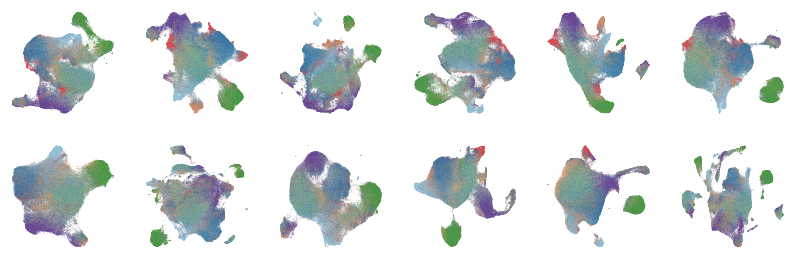

In [14]:
import os
import scanpy as sc


import warnings

warnings.filterwarnings("ignore")


adata_cd8_zheng_2021 = sc.read_h5ad("../data/adata_cd8_zheng_2021.h5ad")
for i in list(
    filter(
        lambda x: x.startswith("adata_cd8_zheng_2021.X") and x.endswith("umap.gpu.npy"),
        os.listdir("embeddings"),
    )
):
    adata_cd8_zheng_2021.obsm[i.split("zheng_2021.")[1].split(".")[0]] = np.load(
        os.path.join("embeddings", i)
    )

zheng_2021_annotation_cmap_cd8["undefined"] = "#F7F7F7"
fig, axes = createSubplots(2, 6, figsize=(14, 4.5))
axes = axes.flatten()
for i, ax in zip(
    [
        "X_gex",
        "X_gex_supervised",
        "X_scVI",
        "X_scPoli",
        "X_scPoli_supervised",
        "X_scANVI",
        "X_SCALEX",
        "X_scanorama",
        "X_harmony",
        "X_seuratv4_rpca",
        "X_seuratv4_cca",
        "X_pca",
    ],
    axes,
):
    if i in adata_cd8_zheng_2021.obsm.keys():
        sc.pl.embedding(
            adata_cd8_zheng_2021[
                np.array(adata_cd8_zheng_2021.obsm[i][:, 0] < 24)
                & np.array(adata_cd8_zheng_2021.obsm[i][:, 1] < 24)
            ],
            color="cell_subtype_zheng_2021",
            basis=i,
            ax=ax,
            show=False,
            legend_loc="none",
            palette=zheng_2021_annotation_cmap_cd8,
        )
        ax.set_title(i)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")

#### Extended Data Figure 3B

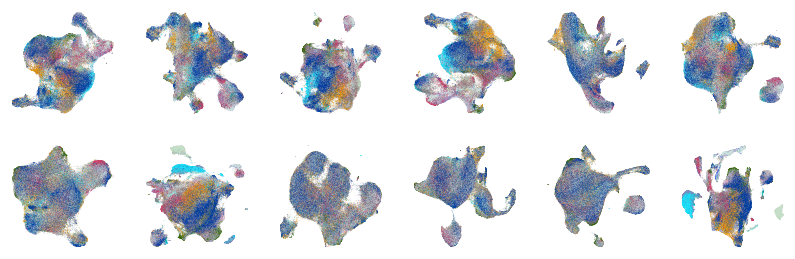

In [16]:
import warnings

warnings.filterwarnings("ignore")


fig, axes = createSubplots(2, 6, figsize=(14, 4.5))
axes = axes.flatten()
for i, ax in zip(
    [
        "X_gex",
        "X_gex_supervised",
        "X_scVI",
        "X_scPoli",
        "X_scPoli_supervised",
        "X_scANVI",
        "X_SCALEX",
        "X_scanorama",
        "X_harmony",
        "X_seuratv4_rpca",
        "X_seuratv4_cca",
        "X_pca",
    ],
    axes,
):
    if i in adata_cd8_zheng_2021.obsm.keys():
        sc.pl.embedding(
            adata_cd8_zheng_2021[
                np.array(adata_cd8_zheng_2021.obsm[i][:, 0] < 24)
                & np.array(adata_cd8_zheng_2021.obsm[i][:, 1] < 24)
            ],
            color="study_name",
            basis=i,
            ax=ax,
            show=False,
            legend_loc="none",
            palette=default_28,
        )
        ax.set_title(i)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")

#### Extended Data Figure 3C

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


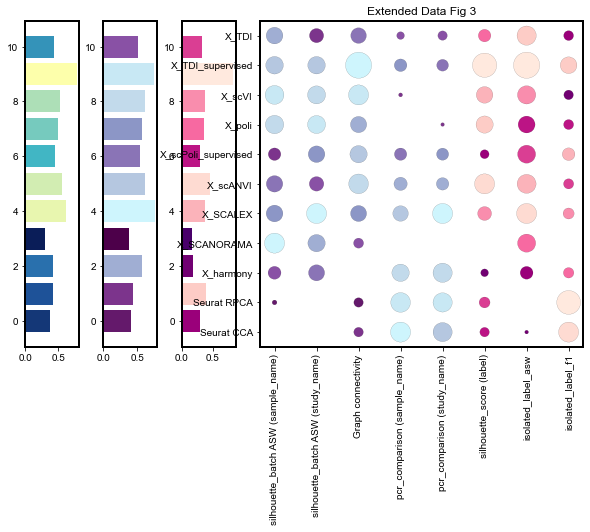

In [8]:
df = pd.read_csv("./Benchmark_zheng_2021.csv", index_col=0)

for i in range(df.shape[1]):
    arr = df.iloc[:, i].to_numpy().flatten()
    df.iloc[:, i] = (arr - arr.min()) / (arr.max() - arr.min())

metrics_batch = [
    "silhouette_batch ASW (sample_name)",
    "silhouette_batch ASW (study_name)",
    "Graph connectivity",
    "pcr_comparison (sample_name)",
    "pcr_comparison (study_name)",
]

metrics_bio = [
    "silhouette_score (label)",
    "isolated_label_asw",
    "isolated_label_f1",
]

df = df.loc[:, metrics_batch + metrics_bio]
df = df.iloc[::-1]
l = list(df.index)

gs_kw = dict(width_ratios=[1, 1, 1, 6])
fig, axes = plt.subplot_mosaic([[0, 1, 2, 3]], gridspec_kw=gs_kw, figsize=(10, 6))

mean_metrics_batch = df.loc[:, metrics_batch].mean(1)
rank = (1 - mean_metrics_batch).rank()
axes[1].barh(
    y=list(range(df.shape[0])),
    width=mean_metrics_batch,
    color=list(
        map(
            lambda x: metric_batch_colormap(1 - x),
            (rank - rank.min()) / (rank.max() - rank.min()),
        )
    ),
)


mean_metrics_bio = df.loc[:, metrics_bio].mean(1)
rank = (1 - mean_metrics_bio).rank()
axes[2].barh(
    y=list(range(df.shape[0])),
    width=mean_metrics_bio,
    color=list(
        map(
            lambda x: metric_bio_colormap(1 - x),
            (rank - rank.min()) / (rank.max() - rank.min()),
        )
    ),
)

mean_metrics_overall = df.mean(1)
rank = (1 - mean_metrics_overall).rank()
axes[0].barh(
    y=list(range(df.shape[0])),
    width=mean_metrics_overall,
    color=list(
        map(
            lambda x: metrics_overall_colormap(1 - x),
            (rank - rank.min()) / (rank.max() - rank.min()),
        )
    ),
)


for i in range(df.shape[1]):
    rank = (1 - df.iloc[:, i]).rank()
    if df.columns[i] in metrics_batch:
        c = list(
            map(
                lambda x: metric_batch_colormap(1 - x),
                (rank - rank.min()) / (rank.max() - rank.min()),
            )
        )
    else:
        c = list(
            map(
                lambda x: metric_bio_colormap(1 - x),
                (rank - rank.min()) / (rank.max() - rank.min()),
            )
        )
    s = df.iloc[:, i]
    s = reject_outliers(s)
    s = (df.iloc[:, i] - s.min()) / (s.max() - s.min())
    axes[3].scatter(
        y=list(range(df.shape[0])),
        x=[i] * df.shape[0],
        s=np.array(s) * 400,
        lw=0.1,
        edgecolor="black",
        c=c,
    )
axes[3].set_yticks(range(df.shape[0]))
axes[3].set_yticklabels(df.index)
axes[3].set_xticks(range(df.shape[1]))
axes[3].set_xticklabels(df.columns, rotation=90)
axes[3].set_title("Extended Data Fig 3")
fig.savefig("./Benchmark_zheng_2021.pdf")

### Extended Data Figure 4

#### Extended Data Figure 4A

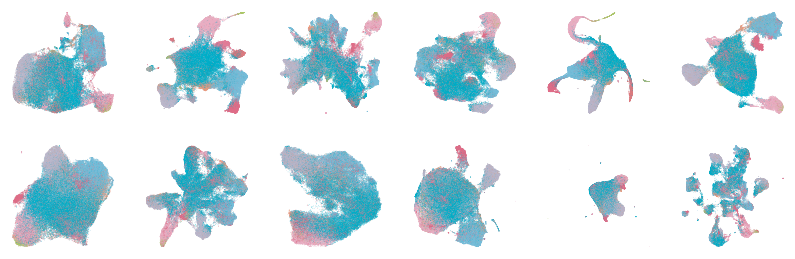

In [21]:
import os
import scanpy as sc


import warnings

warnings.filterwarnings("ignore")


adata_cd8_chu = sc.read_h5ad("../data/adata_cd8_chu.h5ad")
for i in list(
    filter(
        lambda x: x.startswith("adata_cd8_chu.X") and x.endswith("umap.gpu.npy"),
        os.listdir("embeddings"),
    )
):
    adata_cd8_chu.obsm[i.split("chu.")[1].split(".")[0]] = np.load(
        os.path.join("embeddings", i)
    )

zheng_2021_annotation_cmap_cd8["undefined"] = "#F7F7F7"
fig, axes = createSubplots(2, 6, figsize=(14, 4.5))
axes = axes.flatten()
for i, ax in zip(
    [
        "X_gex",
        "X_gex_supervised",
        "X_scVI",
        "X_scPoli",
        "X_scPoli_supervised",
        "X_scANVI",
        "X_SCALEX",
        "X_scanorama",
        "X_harmony",
        "X_seuratv4_rpca",
        "X_seuratv4_cca",
        "X_pca",
    ],
    axes,
):
    if i in adata_cd8_chu.obsm.keys():
        sc.pl.embedding(
            adata_cd8_chu[
                np.array(adata_cd8_chu.obsm[i][:, 0] < 24)
                & np.array(adata_cd8_chu.obsm[i][:, 1] < 24)
            ],
            color="cell_subtype_chu_2023",
            basis=i,
            ax=ax,
            show=False,
            legend_loc="none",
            palette=chu_annotation_cmap_2,
        )

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")

#### Extended Data Figure 4B

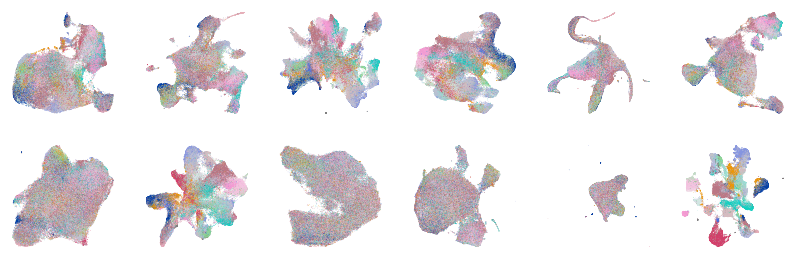

In [24]:
import os
import scanpy as sc


import warnings

warnings.filterwarnings("ignore")


adata_cd8_chu = sc.read_h5ad("../data/adata_cd8_chu.h5ad")
for i in list(
    filter(
        lambda x: x.startswith("adata_cd8_chu.X") and x.endswith("umap.gpu.npy"),
        os.listdir("embeddings"),
    )
):
    adata_cd8_chu.obsm[i.split("chu.")[1].split(".")[0]] = np.load(
        os.path.join("embeddings", i)
    )

zheng_2021_annotation_cmap_cd8["undefined"] = "#F7F7F7"
fig, axes = createSubplots(2, 6, figsize=(14, 4.5))
axes = axes.flatten()
for i, ax in zip(
    [
        "X_gex",
        "X_gex_supervised",
        "X_scVI",
        "X_scPoli",
        "X_scPoli_supervised",
        "X_scANVI",
        "X_SCALEX",
        "X_scanorama",
        "X_harmony",
        "X_seuratv4_rpca",
        "X_seuratv4_cca",
        "X_pca",
    ],
    axes,
):
    if i in adata_cd8_chu.obsm.keys():
        sc.pl.embedding(
            adata_cd8_chu[
                np.array(adata_cd8_chu.obsm[i][:, 0] < 24)
                & np.array(adata_cd8_chu.obsm[i][:, 1] < 24)
            ],
            color="sample_name",
            basis=i,
            ax=ax,
            show=False,
            legend_loc="none",
            palette=default_28,
        )

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")

#### Extended Data Figure 4C

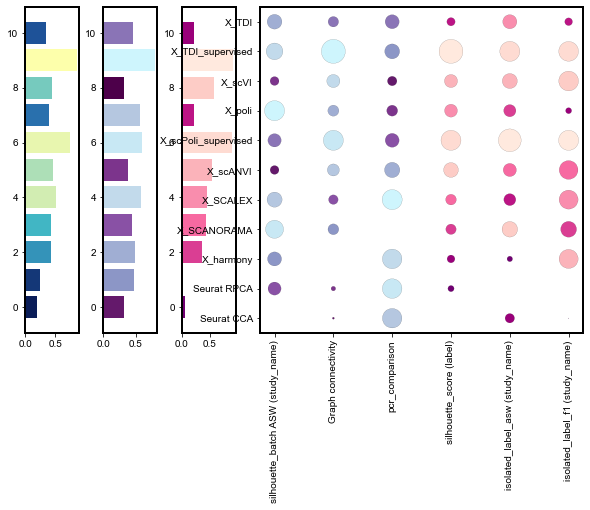

In [3]:
df = pd.read_csv("./benchmark_result_Chu_2023.csv", index_col=0)

for i in range(df.shape[1]):
    arr = df.iloc[:, i].to_numpy().flatten()
    df.iloc[:, i] = (arr - arr.min()) / (arr.max() - arr.min())

metrics_batch = [
    "silhouette_batch ASW (study_name)",
    "Graph connectivity",
    "pcr_comparison",
]

metrics_bio = [
    "silhouette_score (label)",
    "isolated_label_asw (study_name)",
    "isolated_label_f1 (study_name)",
]

df = df[df.index != "X_PCA"]

df = df.loc[:, metrics_batch + metrics_bio]
df = df.iloc[::-1]
l = list(df.index)
# l.remove("X_PCA")
# l = ['X_PCA'] + l
# df = df.loc[l]


gs_kw = dict(width_ratios=[1, 1, 1, 6])
fig, axes = plt.subplot_mosaic([[0, 1, 2, 3]], gridspec_kw=gs_kw, figsize=(10, 6))

mean_metrics_batch = df.loc[:, metrics_batch].mean(1)
rank = (1 - mean_metrics_batch).rank()
axes[1].barh(
    y=list(range(df.shape[0])),
    width=mean_metrics_batch,
    color=list(
        map(
            lambda x: metric_batch_colormap(1 - x),
            (rank - rank.min()) / (rank.max() - rank.min()),
        )
    ),
)


mean_metrics_bio = df.loc[:, metrics_bio].mean(1)
rank = (1 - mean_metrics_bio).rank()
axes[2].barh(
    y=list(range(df.shape[0])),
    width=mean_metrics_bio,
    color=list(
        map(
            lambda x: metric_bio_colormap(1 - x),
            (rank - rank.min()) / (rank.max() - rank.min()),
        )
    ),
)

mean_metrics_overall = df.mean(1)
rank = (1 - mean_metrics_overall).rank()
axes[0].barh(
    y=list(range(df.shape[0])),
    width=mean_metrics_overall,
    color=list(
        map(
            lambda x: metrics_overall_colormap(1 - x),
            (rank - rank.min()) / (rank.max() - rank.min()),
        )
    ),
)


for i in range(df.shape[1]):
    rank = (1 - df.iloc[:, i]).rank()
    if df.columns[i] in metrics_batch:
        c = list(
            map(
                lambda x: metric_batch_colormap(1 - x),
                (rank - rank.min()) / (rank.max() - rank.min()),
            )
        )
    else:
        c = list(
            map(
                lambda x: metric_bio_colormap(1 - x),
                (rank - rank.min()) / (rank.max() - rank.min()),
            )
        )
    s = df.iloc[:, i]
    s = reject_outliers(s)
    s = (df.iloc[:, i] - s.min()) / (s.max() - s.min())
    axes[3].scatter(
        y=list(range(df.shape[0])),
        x=[i] * df.shape[0],
        s=np.array(s) * 400,
        lw=0.1,
        edgecolor="black",
        c=c,
    )
axes[3].set_yticks(range(df.shape[0]))
axes[3].set_yticklabels(df.index)
axes[3].set_xticks(range(df.shape[1]))
axes[3].set_xticklabels(df.columns, rotation=90)
axes[3].set_title("Extended Data Fig 4")
fig.savefig(".figures/benchmark_Chu_2023.pdf")

### Extended Data Figure 5

In [53]:
for i in list(filter(lambda x: x.startswith("huARdb_v2_GEX.CD8.hvg4k.pan_cancer_multi_atlas.X") and x.endswith("umap.gpu.npy"), os.listdir("embeddings"))):
    adata_cd8_multi_atlas.obsm[i.split("multi_atlas.")[1].split(".")[0]] = np.load(os.path.join("embeddings", i))

#### Extended Data Figure 5A

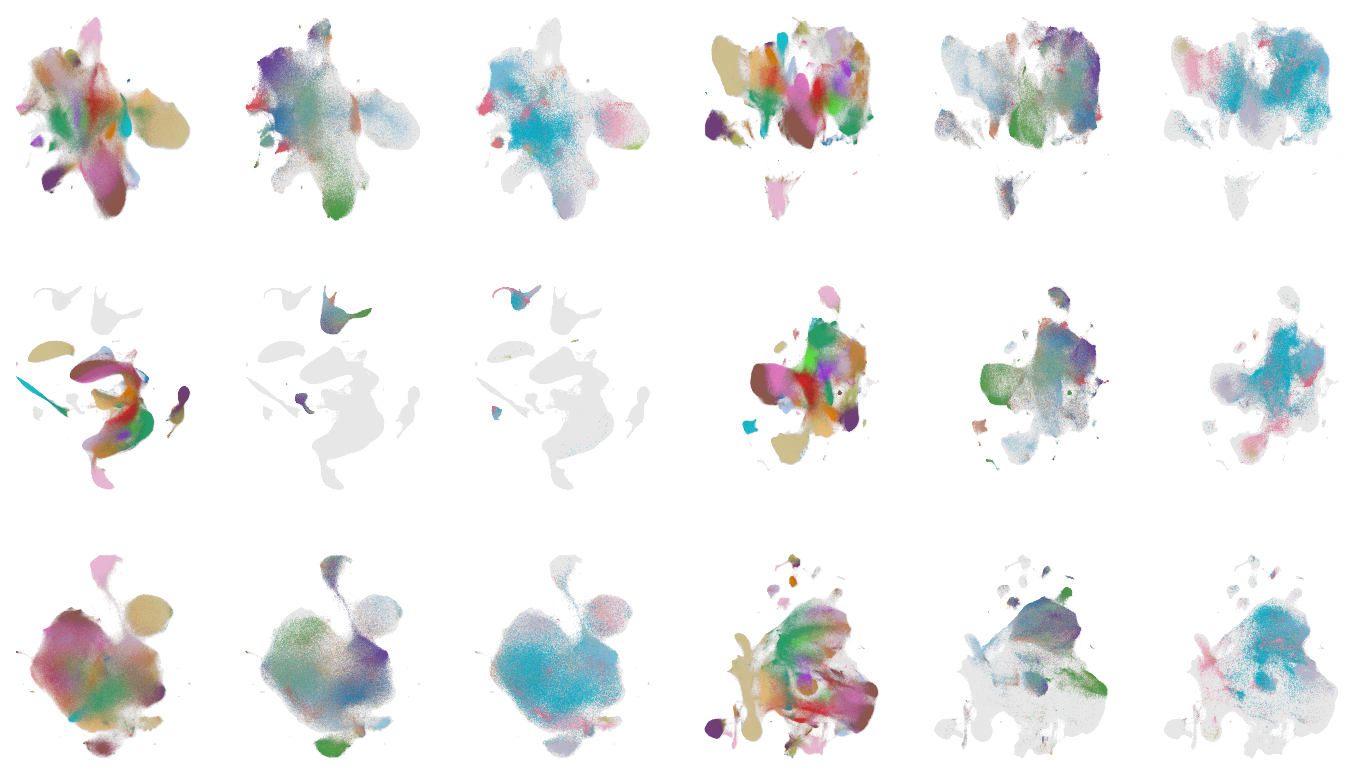

In [54]:
fig, axes = createSubplots(3, 6, figsize=(24, 14))
axes = axes.flatten()
for e, i in enumerate(
    ["X_gex", "X_scVI", "X_scPoli_supervised", "X_scANVI", "X_SCALEX", "X_pca"]
):
    obsm = adata_cd8_multi_atlas.obsm[i]
    for ax in axes[e * 3 : e * 3 + 3]:
        ax.scatter(obsm[:, 0], obsm[:, 1], c="#E7E7E7", s=0.1, lw=0)
    sc.pl.embedding(
        adata_cd8_multi_atlas[
            adata_cd8_multi_atlas.obs["atlas_name"].isin(["Chu_2023"])
        ],
        color="cell_subtype_chu_2023",
        ax=axes[e * 3 + 2],
        palette=chu_annotation_cmap_2,
        show=False,
        basis=i,
        legend_loc="none",
    )
    sc.pl.embedding(
        adata_cd8_multi_atlas[
            adata_cd8_multi_atlas.obs["atlas_name"].isin(["zheng_2021_PanCancer"])
        ],
        color="cell_subtype_zheng_2021",
        ax=axes[e * 3 + 1],
        palette=zheng_2021_annotation_cmap_cd8,
        show=False,
        basis=i,
        legend_loc="none",
    )
    sc.pl.embedding(
        adata_cd8_multi_atlas[
            np.array(adata_cd8_multi_atlas.obs["atlas_name"].isin(["huARdbv2"]))
        ],
        color="cell_subtype_3",
        ax=axes[e * 3 + 0],
        palette=subtype_color,
        show=False,
        basis=i,
        legend_loc="none",
    )
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")

#### Extended Data Figure 5B

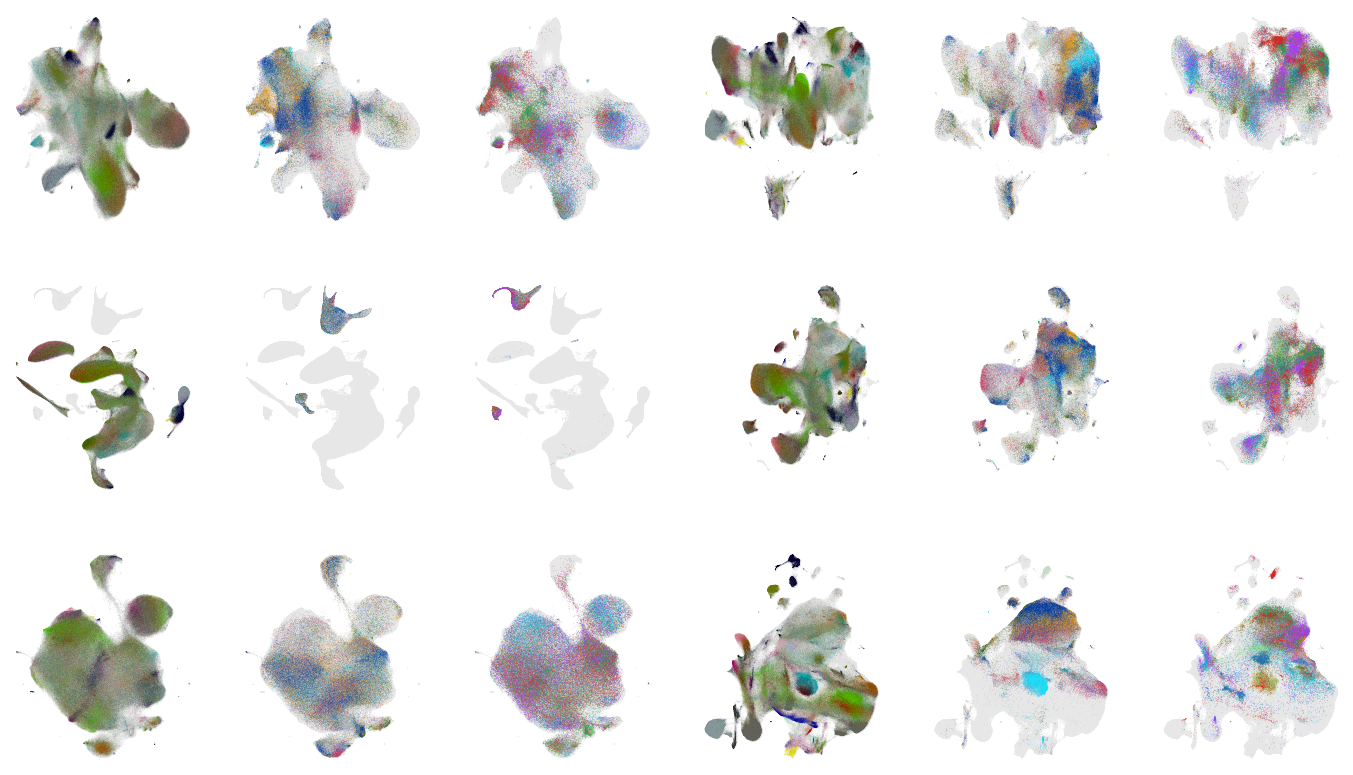

In [55]:
fig, axes = createSubplots(3, 6, figsize=(24, 14))
axes = axes.flatten()
for e, i in enumerate(
    ["X_gex", "X_scVI", "X_scPoli_supervised", "X_scANVI", "X_SCALEX", "X_pca"]
):
    obsm = adata_cd8_multi_atlas.obsm[i]
    for ax in axes[e * 3 : e * 3 + 3]:
        ax.scatter(obsm[:, 0], obsm[:, 1], c="#E7E7E7", s=0.1, lw=0)
    sc.pl.embedding(
        adata_cd8_multi_atlas[
            adata_cd8_multi_atlas.obs["atlas_name"].isin(["Chu_2023"])
        ],
        color="study_name",
        ax=axes[e * 3 + 2],
        palette=default_20,
        show=False,
        basis=i,
        legend_loc="none",
    )
    sc.pl.embedding(
        adata_cd8_multi_atlas[
            adata_cd8_multi_atlas.obs["atlas_name"].isin(["zheng_2021_PanCancer"])
        ],
        color="study_name",
        ax=axes[e * 3 + 1],
        palette=default_28,
        show=False,
        basis=i,
        legend_loc="none",
    )
    sc.pl.embedding(
        adata_cd8_multi_atlas[
            np.array(adata_cd8_multi_atlas.obs["atlas_name"].isin(["huARdbv2"]))
        ],
        color="study_name",
        ax=axes[e * 3 + 0],
        palette=godsnot_102,
        show=False,
        basis=i,
        legend_loc="none",
    )
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")

### Extended Data Figure 6

#### Extended Data Figure 6D

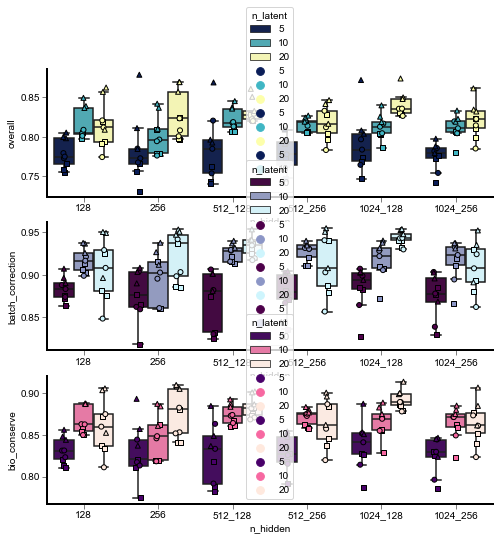

In [56]:
df_all = pd.read_csv("./Benchmark_hyperparameter_all.csv")
df_all["n_hidden_int"] = df_all["n_hidden"].apply(
    lambda x: (int(x.split("_")[0]), int(x.split("_")[-1]))
)
metrics_batch_colormap = [
    "#4D004A",
    "#8C96C6",
    "#CEF5FD",
]

metrics_bio_colormap = [
    "#49006A",
    "#F768A1",
    "#FFE9DE",
]

metrics_overall_colormap = [
    "#0A1D58",
    "#40B6C4",
    "#FDFFAB",
]


fig, ax = createSubplots(3, 1)
markdict = {
    "cell_subtype_revision": "s",
    "cell_subtype_zheng_2021": "o",
    "cell_subtype_chu_2023": "^",
}

sns.boxplot(
    data=df_all.sort_values("n_hidden_int"),
    x="n_hidden",
    y="overall",
    hue="n_latent",
    ax=ax[0],
    showfliers=False,
    palette=metrics_overall_colormap,
)
for k, v in markdict.items():
    sns.stripplot(
        data=df_all[df_all["atlas_name"] == k].sort_values("n_hidden_int"),
        x="n_hidden",
        y="overall",
        hue="n_latent",
        ax=ax[0],
        dodge=True,
        marker=v,
        edgecolor="black",
        linewidth=1,
        palette=metrics_overall_colormap,
    )

sns.boxplot(
    data=df_all.sort_values("n_hidden_int"),
    x="n_hidden",
    y="batch_correction",
    hue="n_latent",
    ax=ax[1],
    showfliers=False,
    palette=metrics_batch_colormap,
)
for k, v in markdict.items():
    sns.stripplot(
        data=df_all[df_all["atlas_name"] == k].sort_values("n_hidden_int"),
        x="n_hidden",
        y="batch_correction",
        hue="n_latent",
        ax=ax[1],
        dodge=True,
        marker=v,
        edgecolor="black",
        linewidth=1,
        palette=metrics_batch_colormap,
    )

sns.boxplot(
    data=df_all.sort_values("n_hidden_int"),
    x="n_hidden",
    y="bio_conserve",
    hue="n_latent",
    ax=ax[2],
    showfliers=False,
    palette=metrics_bio_colormap,
)
for k, v in markdict.items():
    sns.stripplot(
        data=df_all[df_all["atlas_name"] == k].sort_values("n_hidden_int"),
        x="n_hidden",
        y="bio_conserve",
        hue="n_latent",
        ax=ax[2],
        dodge=True,
        marker=v,
        edgecolor="black",
        linewidth=1,
        palette=metrics_bio_colormap,
    )